# 1. Business Understanding
In the context of the CRISP-DM framework, the task of identifying the key drivers of exceeding the $50K income threshold can be reframed as a data analysis problem as follows:

The primary objective is to conduct an assessment of the Scope and Quality of the dataset containing ~43k entries to drive subsequent dataset cleaning. This involves the identification of missing data, skewed histograms, under-represented input variables, inconsistent data, duplicates, outlier values, and imbalances in the target variable classes. 

This is followed by an Exploratory Data Analysis (EDA) to uncover trends, patterns, and relationships. This involves statistical analysis and visualizations to understand the distribution and characteristics of the input features in the dataset (e.g. age, education, race, gender).

In the data preparation phase of the CRISP-DM process, the focus is on cleaning, pre-processing, and transforming the dataset to make it suitable for analysis and modeling based on the findings from the earlier scope and quality checks. This phase is crucial as the quality of data significantly affects the outcome of the analysis.

In the modeling phase, the task progresses to predictive modeling, where the goal is to select the best classification model from several trained, tuned, and validated models based on the dataset. Models are trained and tuned using hyper-parameters to aid in the identification better models. Before training the model(s), the cleaned dataset is split into training and test datasets. Numeric columns are scaled and categorical columns are encoded to numeric values.

Once a set of validated models is identified, the best, validated model is selected for deployment, and feature importances are extracted to complement the earlier conclusions derived from the Exploratory Data Analysis (EDA).  

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics             import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics             import precision_recall_curve, average_precision_score
from sklearn.model_selection     import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.model_selection     import KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics             import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.preprocessing       import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.neighbors           import KNeighborsClassifier
from sklearn.linear_model        import LogisticRegression
from sklearn.tree                import DecisionTreeClassifier
from sklearn.ensemble            import RandomForestClassifier
from sklearn.svm                 import SVC
from sklearn.neural_network      import MLPClassifier

from functools                   import partial
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers           import KerasClassifier

from sklearn.compose             import ColumnTransformer
from sklearn.impute              import SimpleImputer
from sklearn.pipeline            import Pipeline

from scipy.stats                 import sem
from imblearn.over_sampling      import RandomOverSampler, SMOTE
from imblearn.combine            import SMOTETomek
from imblearn.pipeline           import Pipeline as ImbPipeline

%matplotlib inline

# 2. Data Understanding
This part involves exploring the dataset to understand its structure, quality, and the types of information it contains. It's implemented with four steps:

1. Understanding Data Scope
2. Understanding data types.
3. Understanding data quality.
4. Completing Exploratory Data Anlysis.

## 2.1: Data Scope
Obtain a general sense of the size and content of the dataset. Determine the column that will serve as the target variable, and which columns will serve as inputs to the analysis.

In [2]:
# Import data
df = pd.read_csv("DATA/income.csv")

In [3]:
df.sample(5)

age workclass  fnlwgt   education  educational-num      marital-status  \
617     24   Private  304386     HS-grad                9       Never-married   
8571    37   Private  162164     HS-grad                9  Married-civ-spouse   
1872    62   Private  343982        10th                6             Widowed   
32748   44   Private  184378   Assoc-voc               11  Married-civ-spouse   
21428   47   Private  234470  Assoc-acdm               12             Widowed   

            occupation relationship   race  gender  capital-gain  \
617      Other-service    Own-child  White  Female             0   
8571      Craft-repair      Husband  White    Male             0   
1872      Adm-clerical    Own-child  Black  Female             0   
32748  Exec-managerial      Husband  White    Male             0   
21428     Adm-clerical    Unmarried  Black  Female             0   

       capital-loss  hours-per-week native-country  income_>50K  
617               0              30  United-States            0  
8571              0              40  United-States            0  
1872              0              40  United-States            0  
32748             0              40  United-States            0  
21428             0              40  United-States            0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational-num  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43194 non-null  object
 14  income_>50K      43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


In [5]:
df.describe()

age        fnlwgt  educational-num  capital-gain  \
count  43957.000000  4.395700e+04     43957.000000  43957.000000   
mean      38.617149  1.896730e+05        10.074118   1093.559797   
std       13.734401  1.058215e+05         2.575092   7570.536063   
min       17.000000  1.349200e+04         1.000000      0.000000   
25%       28.000000  1.174960e+05         9.000000      0.000000   
50%       37.000000  1.781000e+05        10.000000      0.000000   
75%       48.000000  2.376710e+05        12.000000      0.000000   
max       90.000000  1.490400e+06        16.000000  99999.000000   

       capital-loss  hours-per-week   income_>50K  
count  43957.000000    43957.000000  43957.000000  
mean      88.246491       40.407694      0.239279  
std      404.588410       12.400303      0.426648  
min        0.000000        1.000000      0.000000  
25%        0.000000       40.000000      0.000000  
50%        0.000000       40.000000      0.000000  
75%        0.000000       45.000000      0.000000  
max     4356.000000       99.000000      1.000000

## 2.2: Data Types and Classes
Obtain the data type of each column. Determine which columns are numerical and which are categorical. Dtermine the acceptable ranges for numerical values. Determine the number of unique values in each categorical column as well as the acceptable values for each column. Identify derived columns and/or data transformations that might be useful for the analysis.

In [6]:
################################################################################################################################
#Determine the unique values for each column
################################################################################################################################
for col in df.columns:
    print(f"# of Unique values in '{col}':", df[col].nunique())
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print()
    
#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
#Can implement single column incoding for 'default', 'housing', 'loan', and '' columns

# of Unique values in 'age': 74
Unique values in 'age':
[67 17 31 58 25 59 70 35 28 21 30 20 45 76 54 19 44 47 37 27 24 49 36 71
 62 64 53 34 42 26 43 23 56 40 63 50 29 52 33 38 66 46 32 68 41 80 73 39
 57 51 69 22 18 55 65 60 48 61 72 90 74 77 75 81 82 88 84 83 79 78 85 89
 87 86]

# of Unique values in 'workclass': 8
Unique values in 'workclass':
['Private' 'State-gov' 'Self-emp-not-inc' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' nan 'Never-worked' 'Without-pay']

# of Unique values in 'fnlwgt': 26646
Unique values in 'fnlwgt':
[366425 244602 174201 ...  68982 116562 375827]

# of Unique values in 'education': 16
Unique values in 'education':
['Doctorate' '12th' 'Bachelors' '7th-8th' 'Some-college' 'HS-grad' '9th'
 '10th' '11th' 'Masters' 'Preschool' '5th-6th' 'Prof-school' 'Assoc-voc'
 '1st-4th' 'Assoc-acdm']

# of Unique values in 'educational-num': 16
Unique values in 'educational-num':
[16  8 13  4 10  9  5  6  7 14  1  3 15 11  2 12]

# of Unique values in 'marital-status': 7
Uni

## 2.3: Data Quality
Assess the data quality. Determine if there are any duplicate entries, missing values, and inconsistencies between columns. Develop strategies for dealing with them. For example, misclassifications in one column can often be determined and corrected based on information in another column.

In [7]:
################################################################################################################################
# Check the numeric columns for specific values or ranges of values
################################################################################################################################
num_cols = df.select_dtypes(include=['int64', 'float64'])

# Initialize a DataFrame to hold the counts
count_table = pd.DataFrame(index=num_cols.columns, columns=['== -1','<  0', '==  0', '>  0', '==  1', 'NaN', 'Min', 'Max'])

# Populate the table with counts
for column in num_cols.columns:
    count_table.loc[column, '== -1'] = (num_cols[column] == -1).sum()
    count_table.loc[column,  '<  0'] = (num_cols[column] <   0).sum()
    count_table.loc[column, '==  0'] = (num_cols[column] ==  0).sum()
    count_table.loc[column,  '>  0'] = (num_cols[column] >   0).sum()
    count_table.loc[column, '==  1'] = (num_cols[column] ==  1).sum()
    count_table.loc[column, '==  ?'] = (num_cols[column] ==  1).sum()
    count_table.loc[column,   'NaN'] =  num_cols[column].isna().sum()
    count_table.loc[column,   'Min'] =  num_cols[column].min()
    count_table.loc[column,   'Max'] =  num_cols[column].max()

count_table

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Capital gain and loss columns can be combined by subtracting the loss column from the gain column.

== -1 <  0  ==  0   >  0  ==  1 NaN    Min      Max    ==  ?
age                 0    0      0  43957      0   0     17       90      0.0
fnlwgt              0    0      0  43957      0   0  13492  1490400      0.0
educational-num     0    0      0  43957     76   0      1       16     76.0
capital-gain        0    0  40330   3627      0   0      0    99999      0.0
capital-loss        0    0  41884   2073      0   0      0     4356      0.0
hours-per-week      0    0      0  43957     26   0      1       99     26.0
income_>50K         0    0  33439  10518  10518   0      0        1  10518.0

In [8]:
################################################################################################################################
# Check for the percentage of missing values designated as 'NaN'
################################################################################################################################
object_columns_df = df.select_dtypes(include=['object'])
nan_percent = object_columns_df.isnull().sum() / object_columns_df.shape[0] * 100
nan_percent_formatted = nan_percent.round(1).astype(str) + ' %'
print(nan_percent_formatted)

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# There are very few missing values. Therefore, rows with missing values can simply be dropped from the dataset
# Capital-gain and Capital-loss columns are sparsely populated with non-zero values. Therefore, they are dropped from the dataset.

workclass         5.7 %
education         0.0 %
marital-status    0.0 %
occupation        5.7 %
relationship      0.0 %
race              0.0 %
gender            0.0 %
native-country    1.7 %
dtype: object


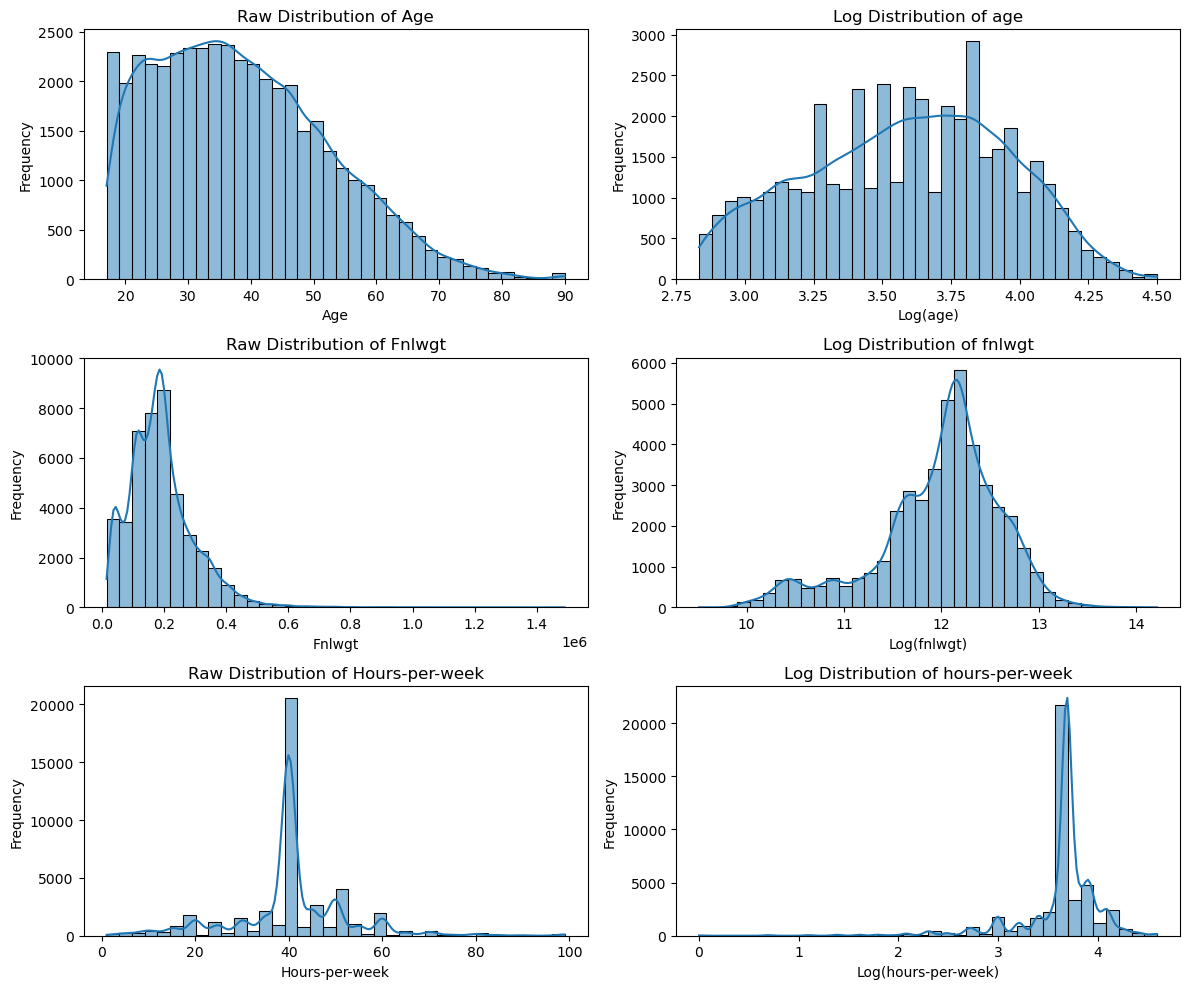

In [9]:
################################################################################################################################
# Check histograms of all Continuous Numeric Variables
################################################################################################################################

import warnings
warnings.filterwarnings("ignore")

# list of numerical features
features = ['age', 'fnlwgt', 'hours-per-week']

# Setting up the subplot environment
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 10))

# Loop through the features for side-by-side plots
for i, feature in enumerate(features):

    # Raw data plot on the left
    sns.histplot(df[feature], bins=36, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Raw Distribution of {feature.capitalize()}')
    axes[i, 0].set_xlabel(feature.capitalize())
    axes[i, 0].set_ylabel('Frequency')
    
    # Log transformation and plot on the right, excluding NaN values for 'pdays'
    sns.histplot(np.log(df[feature]), bins=36, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Log Distribution of {feature}')
    axes[i, 1].set_xlabel(f'Log({feature})')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# The distributions of all the continuous numeric variables are improved by taking their log values. Therefore, we'll want to
# the raw values with log values as inputs to our models.

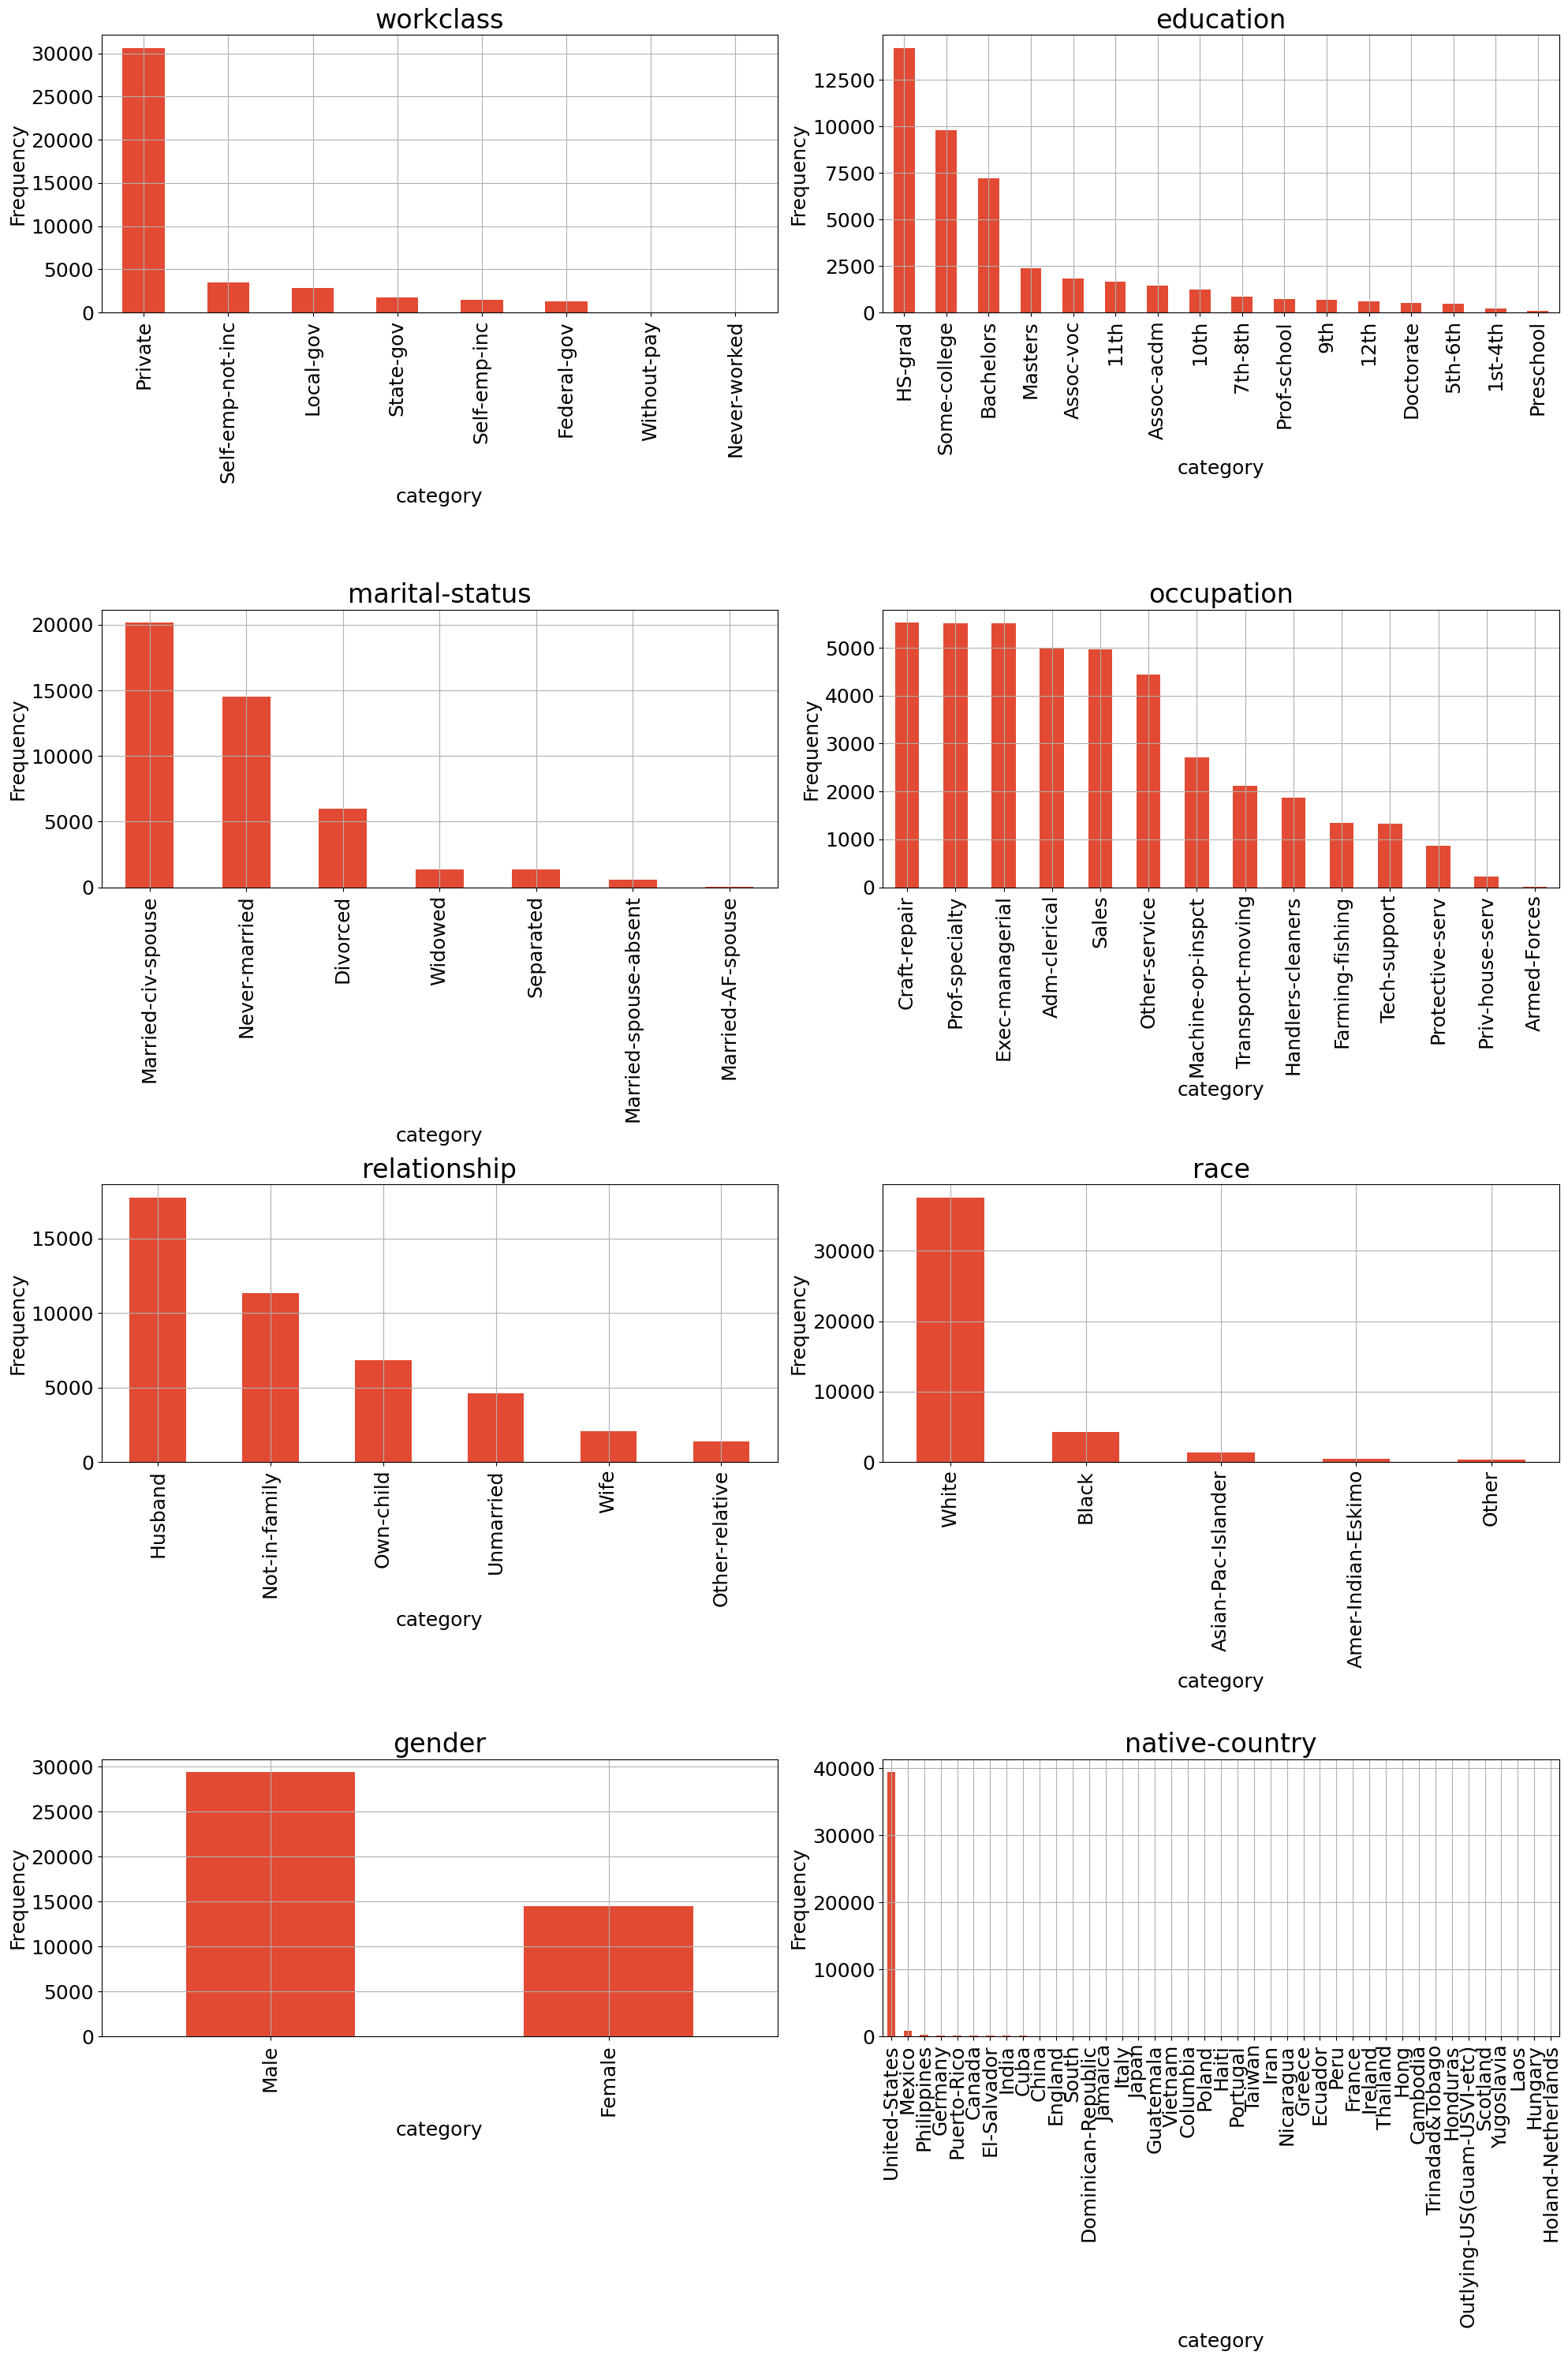

In [10]:
################################################################################################################################
# Determine raw Class Counts
################################################################################################################################

cat_var = df.select_dtypes(include=["object"]).columns

# Setting up the matplotlib figure and axes for a 5x2 subplot
fig, axs = plt.subplots(4, 2, figsize=(20, 30))  # Adjust the figure size as necessary
plt.style.use("ggplot")

# Flattening the axes array for easy iteration
axs = axs.flatten()

for i, column in enumerate(cat_var):
    if i < 10:  # Ensuring we only plot for the first 10 categorical variables
        df[column].value_counts().plot(kind="bar", ax=axs[i])
        axs[i].set_xlabel(column)
        axs[i].set_ylabel("number of customers")
        axs[i].set_title(column, fontsize=24)
    else:
        break  # Exit the loop if there are more than 10 categorical variables
    axs[i].set_xlabel("category", fontsize=18)  # Increase font size for x-axis label
    axs[i].set_ylabel('Frequency', fontsize=18)  # Increase font size for y-axis label
    axs[i].tick_params(axis='x', rotation=90, labelsize=18)  # Increase font size for x-axis tick labels
    axs[i].tick_params(axis='y', labelsize=18)  # Increase font size for y-axis tick labels
       

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Raw counts of Native-Born individuals overwhelmingly dominate over Foreign-Born individuals in the dataset. Parameter
# importances likely to be different for Native- vs. Foreign-Born individuals. Native- and Foreign-Born individuals are to be
# segmented into separate datasets. Models will then be separately trained on each dataset. Parameter importances are to be
# determined separately for Native- and Foreign-Born individuals.

# 1. Individuals working in the private sector workclass overwhelmingly dominate the dataset. Need to be careful when drawing
#    conclusions based on workclass as under-represented workclasses may exhibit skewed results.
# 2. Raw counts of individuals dwindle as the level of education increases above a diploma.
# 3. The dataset is well-balanced between married and single individuals.
# 4. White individuals overwhelmingly dominate the dataset. Need to be careful when drawing conclusions based on race as under-
#    represented races may exhibit skewed results.
# 5. There are twice as many Males as Females in the dataset.

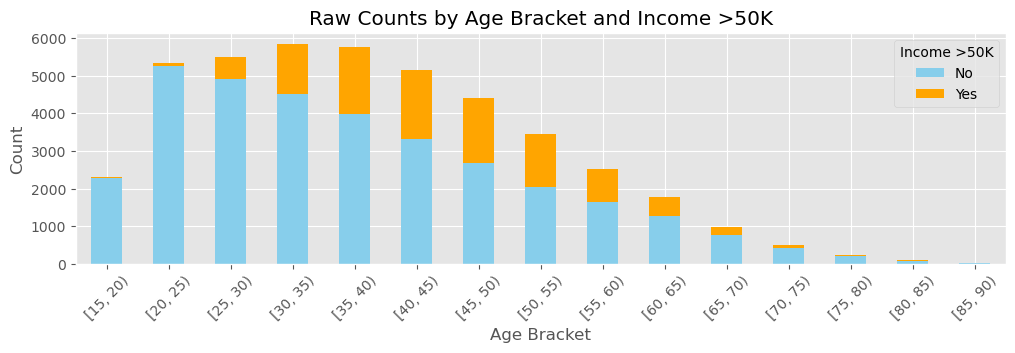

In [11]:
#################################################################################################################
# Target Variable Class Counts by binned Age
#================================================================================================================
# Assuming 'df' is your DataFrame and it contains 'age' and 'income_>50K' columns
max_age = df['age'].max()
bins = np.arange(15, max_age + 5, 5)  # Creating bins from min age to max age, every 5 years
df['age_bracket'] = pd.cut(df['age'], bins, right=False)  # Categorizing ages into bins

# Group by 'age_bracket' and 'income_>50K', then count the number of occurrences
age_bin_grouped = df.groupby(['age_bracket', 'income_>50K']).size().unstack(fill_value=0)

# Plotting directly with specified figure size
age_bin_grouped.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(12, 3))  # Specifying figure size here
plt.title("Raw Counts by Age Bracket and Income >50K")
plt.xlabel("Age Bracket")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Income >50K', labels=['No', 'Yes'])  # Customize the legend
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Values at the tails of the distribution are NOT adequately represented in the dataset. As part of dataset cleaning, rows will
# be removed for individuals outside the range of 18 to 75 years of age.


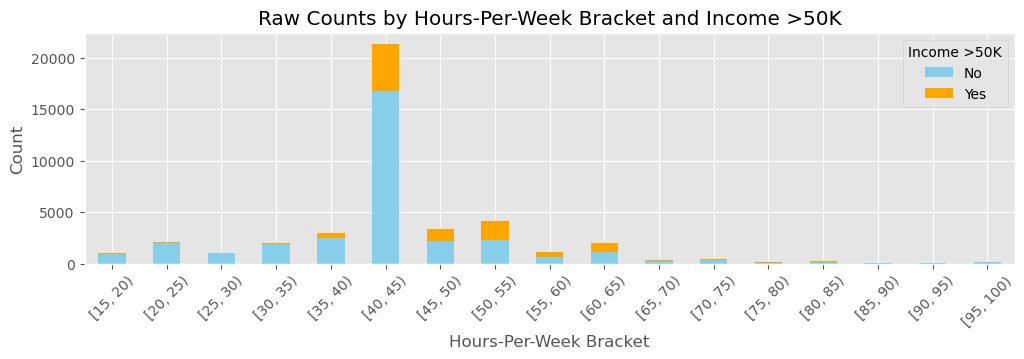

In [12]:
#################################################################################################################
# Target Variable Class Counts by Binned Hours-Per-Week
#================================================================================================================
# Assuming 'df' is your DataFrame and it contains 'age' and 'income_>50K' columns
max_age = df['hours-per-week'].max()
bins = np.arange(15, max_age + 5, 5)  # Creating bins from min age to max age, every 5 years
df['hours-per-week_bracket'] = pd.cut(df['hours-per-week'], bins, right=False)  # Categorizing ages into bins

# Group by 'age_bracket' and 'income_>50K', then count the number of occurrences
age_bin_grouped = df.groupby(['hours-per-week_bracket', 'income_>50K']).size().unstack(fill_value=0)

# Plotting directly with specified figure size
age_bin_grouped.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(12, 3))  # Specifying figure size here
plt.title("Raw Counts by Hours-Per-Week Bracket and Income >50K")
plt.xlabel("Hours-Per-Week Bracket")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Income >50K', labels=['No', 'Yes'])  # Customize the legend
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Values at upper end of the distribution are NOT adequately represented in the dataset. As part of dataset cleaning, rows will
# be removed for individuals outside the range of 15 to 65 hours per week.

<Axes: xlabel='income_>50K', ylabel='count'>

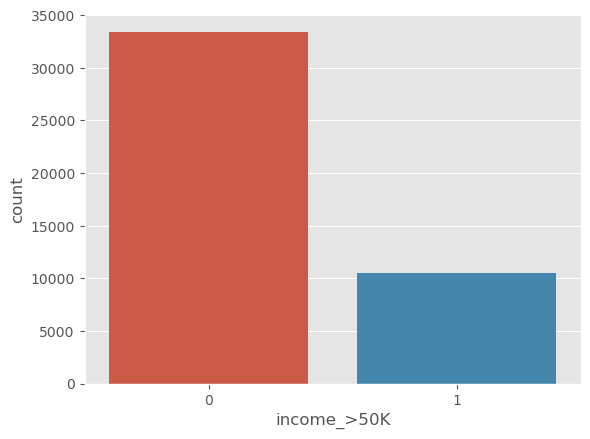

In [13]:
################################################################################################################################
# Target Class Counts
################################################################################################################################
sns.countplot(data=df,x='income_>50K')

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Target variable has only two classes: 1 and 0, where 1 => >$50K and 0 => <=$50K
# The target variable is imbalanced with approximately 3.5 times the number of 0 to 1 values. Therefore, we will want to either 
# balance the dataset or use F1 as the scoring criteria for optimizing models.

## 2.4: Exploratory Data Analysis (EDA)
Use bar plots, to get a sense of the relationships between the columns. Develop strategies. Identify opportunities for model simplification, particularly with respect to the numerical columns, which may have interdependencies as identified by principal componenents analysis.

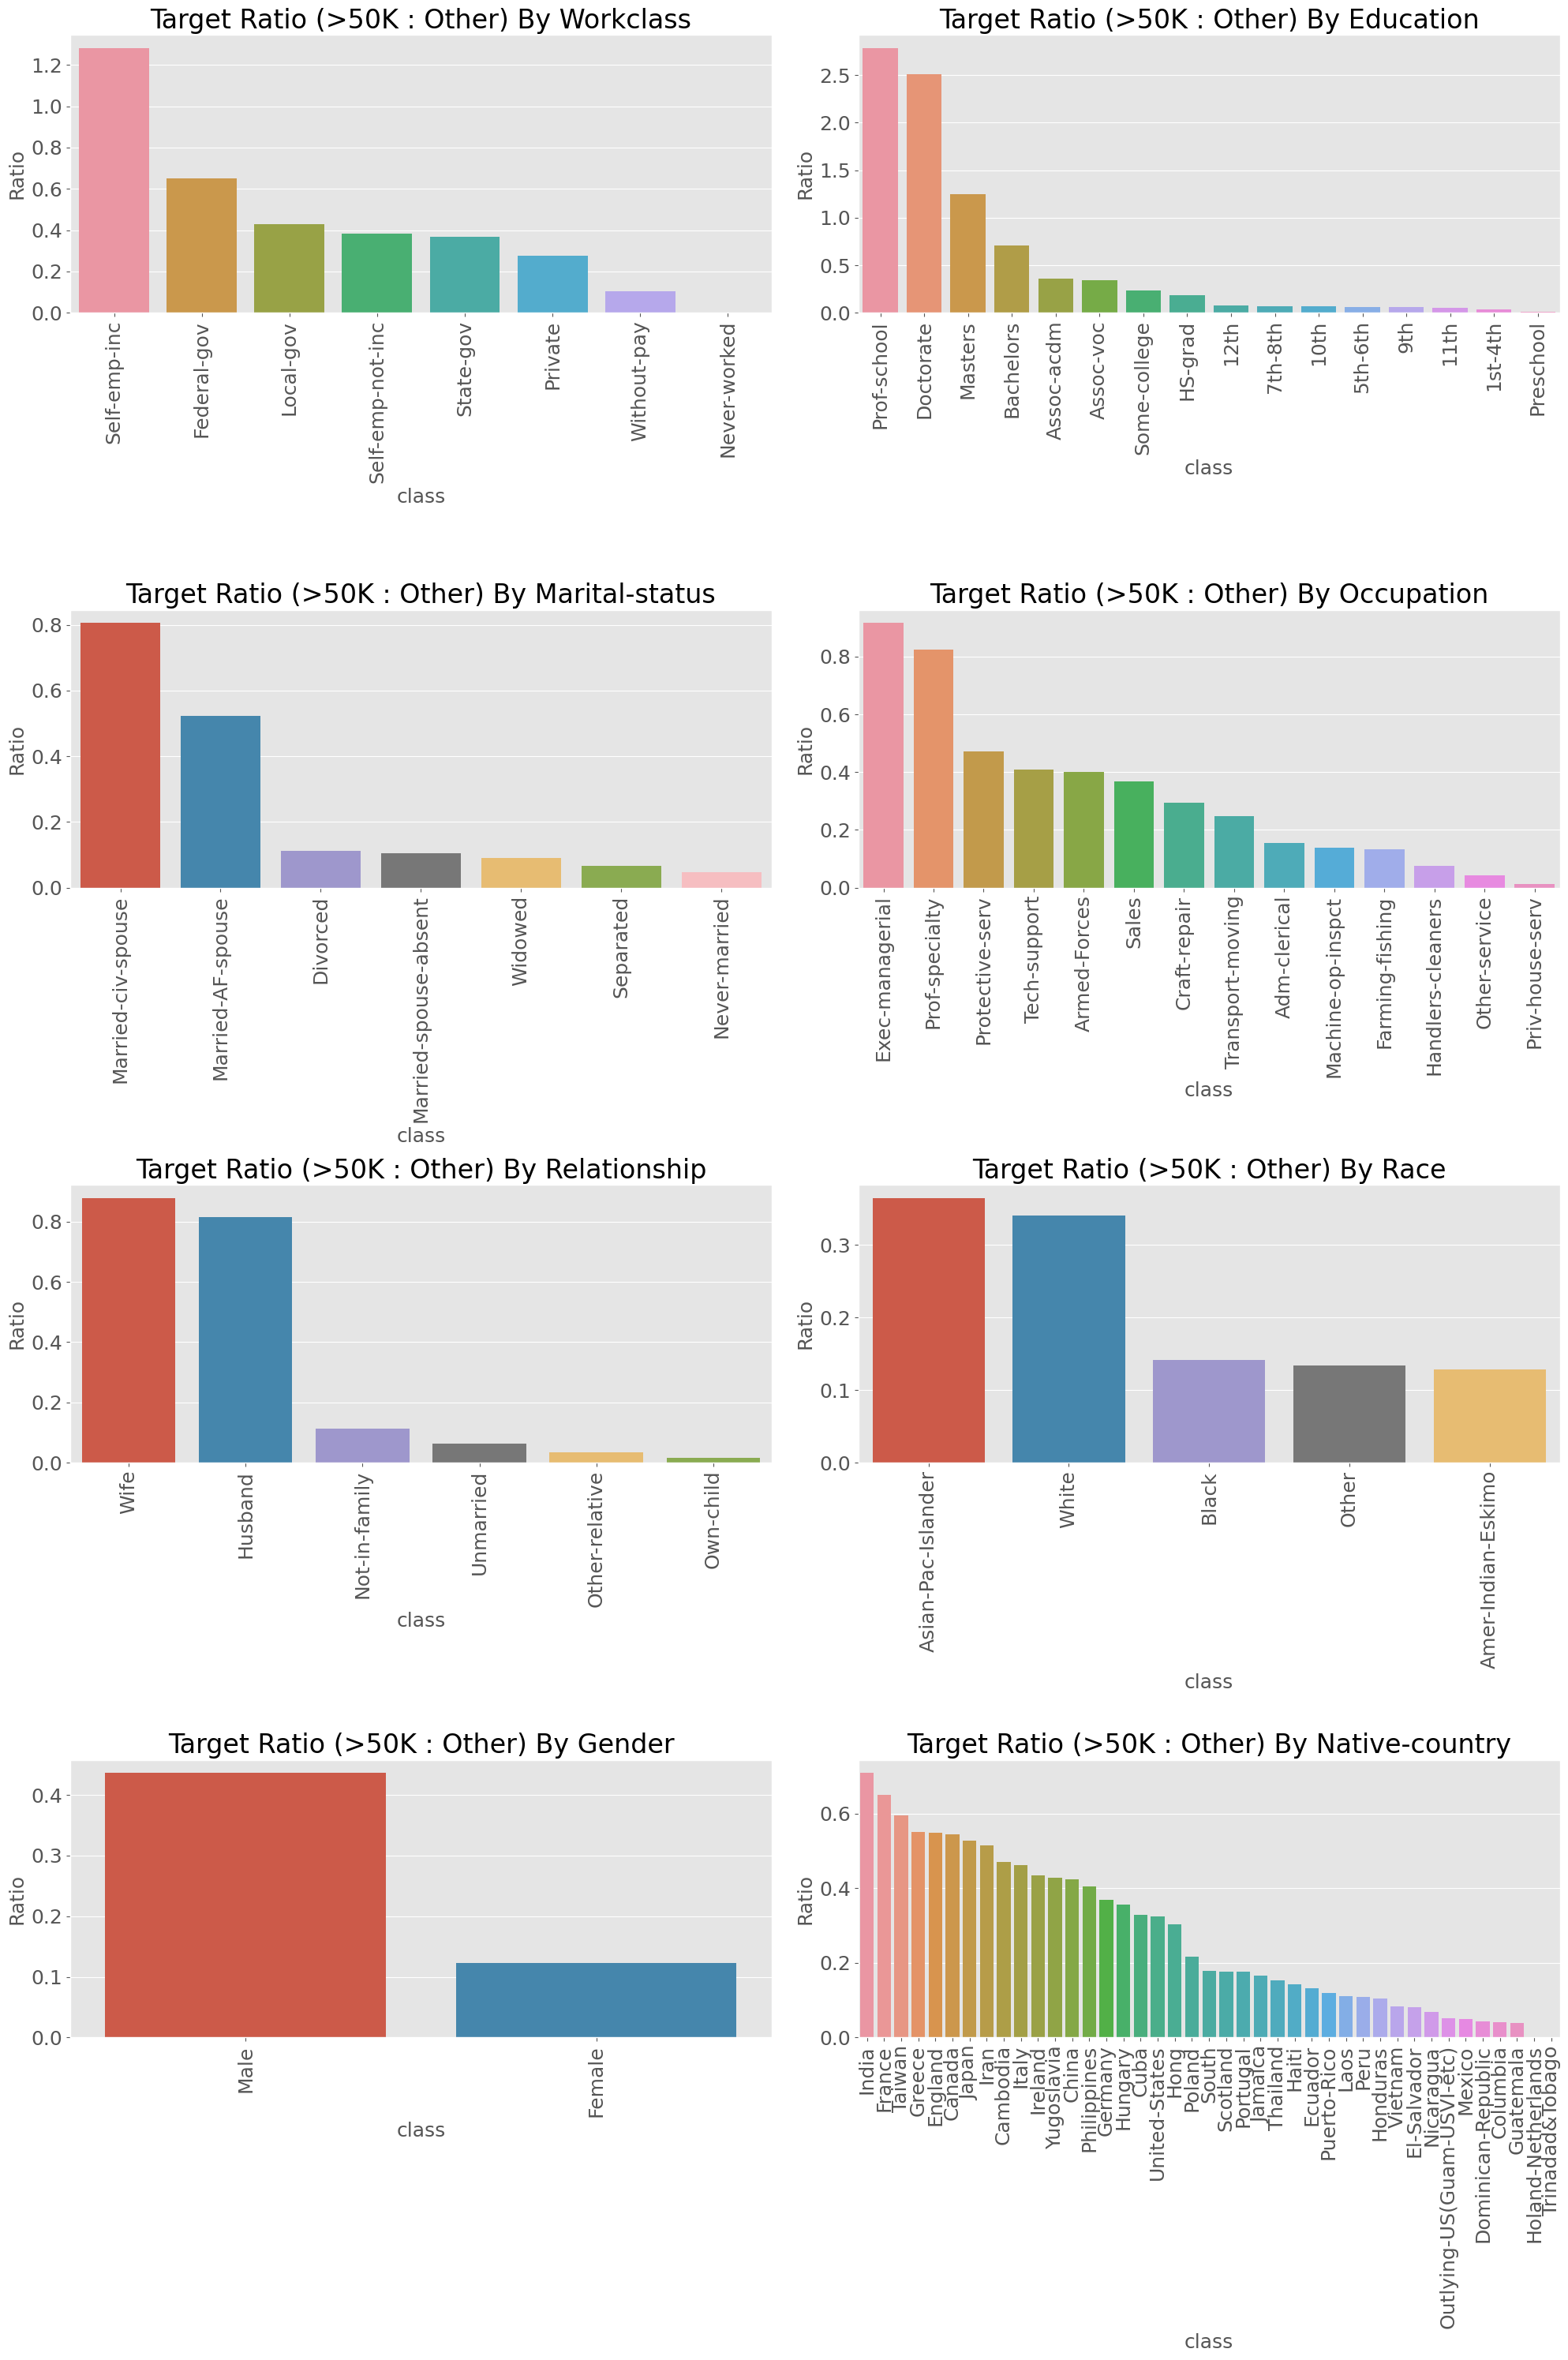

In [14]:
plt.style.use("ggplot")

cat_var = df.select_dtypes(include=["object"]).columns

# Adjust subplot dimensions based on the number of categorical variables
n_cols = 2
n_rows = len(cat_var) // n_cols + (len(cat_var) % n_cols > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axs = axs.ravel()  # Flatten the array of axes for easier indexing

for i, col in enumerate(cat_var):
    if i >= len(axs):
        break

    # Calculate the ratio of 1 to 0 values for each category and sort by ratio
    category_grouped = df.groupby([col, 'income_>50K']).size().unstack().fillna(0)
    category_grouped['ratio'] = category_grouped[1] / (category_grouped[0] + 1)  # Avoid division by zero
    category_grouped.sort_values('ratio', ascending=False, inplace=True)  # Sort by ratio in descending order

    category_grouped.reset_index(inplace=True)

    sns.barplot(x=col, y='ratio', data=category_grouped, ax=axs[i])
    axs[i].set_title(f'Target Ratio (>50K : Other) By {col.capitalize()}', fontsize=24)  # Increase font size for title
    axs[i].set_xlabel ("class" , fontsize=18 )  # Increase font size for x-axis label
    axs[i].set_ylabel ('Ratio' , fontsize=18 )  # Increase font size for y-axis label
    axs[i].tick_params(axis='x', labelsize=18, rotation=90)  # Increase font size for x-axis tick labels
    axs[i].tick_params(axis='y', labelsize=18)  # Increase font size for y-axis tick labels

# Handle odd number of subplots: hide the last ax if unused.
if len(cat_var) % n_cols:
    axs[-1].set_visible(False)  # Hide the last ax if there's an odd number of categorical variables

plt.tight_layout()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# In the "Education" column, all classes representing less than a high school diploma have similar target ratios. This implies
# that the differentiation of education levels below a high school diploma provides little if no insight into the drivers of
# income level. Therefore, all classes representing education levels of less than a high school diploma are to be aggregated into
# a single class during dataset clean-up.
#
# 1. Entrepreneurs are more likely to exceed $50K income threshold, followed by individuals working in Federal, State, and Local
#    governments, and individuals working in the private sector.
# 2. Higher levels of education correspond with higher probabilities of exceeding the $50K income threshold.
# 3. Married individuals are far likelier than single individuals to exceed the $50K income threshold.
# 4. Whites are far likelier than other races to exceed the $50K income threshold. Note: Asian-Pacific Islanders class exceeds 
#    Whites, but could be an anomalous result due to the sparse representation of this class in the dataset.
# 5. Males are far likelier to exceed the $50K income threshold.
# 6. Foreign-Born individuals originating from the Caribbean and Central/South America are the least likely to exceed the $50K
#    income threshold. Also, Foreign-Born from Canada, Europe, and Asia are the most likely to exceed the $50K income threshold.

Text(0.5, 1.0, 'Target Ratio (>50K : Other) by Age Bracket')

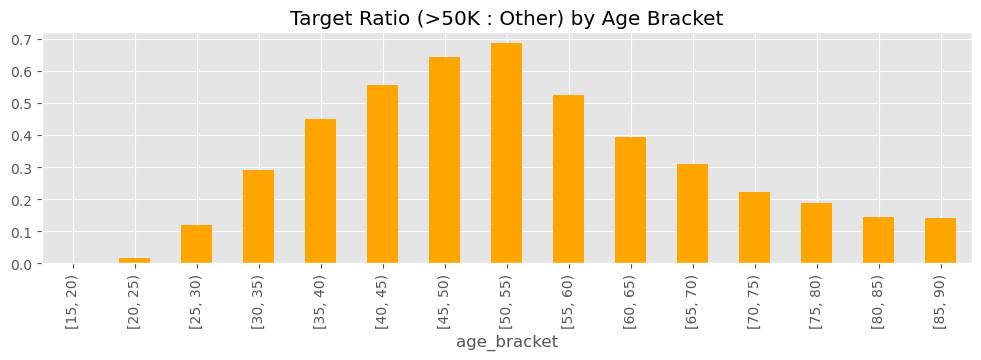

In [15]:
#################################################################################################################
#Target Variable Ratio (>50K : Other) for Binned Age Groups
#================================================================================================================
# Bin ages by every 5 years
max_age = df['age'].max()
bins = np.arange(15, max_age + 5, 5)  # Creating bins from min age to max age, every 5 years


# Calculate counts of 'yes' and 'no' responses for each age bin
age_bin_grouped = df.groupby('age_bracket')['income_>50K'].value_counts().unstack().fillna(0)

# Compute the ratio of 'yes' to 'no' for each age bin
age_bin_grouped['ratio'] = age_bin_grouped[1] / (age_bin_grouped[0] + 1)

# Plot the ratios
plt.figure(figsize=(12, 3))
age_bin_grouped['ratio'].plot(kind='bar', color='orange')
plt.title("Target Ratio (>50K : Other) by Age Bracket")

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Likelihood of exceeding the $50K income threshold increases with age up to 55 years and decreases thereafter. Initial increase
# likely represents greater experience with age while subsequent decrease represents labor force dropout due to retirement of
# older individuals.


Text(0.5, 1.0, 'Target Ratio (>50K : Other) by Hours-Per-Week Bracket')

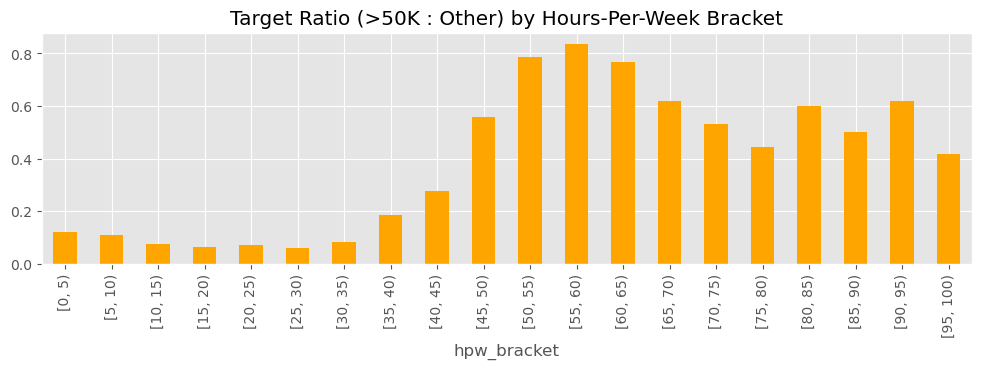

In [16]:
#################################################################################################################
#Target Variable Ratio (>50K : Other) for Binned Hours-Per-Week Groups
#================================================================================================================

# Bin ages by every 5 years
bins = np.arange(0,  df['hours-per-week'].max() + 5, 5)  # Creating bins from min to max, every 5 years
df['hpw_bracket'] = pd.cut(df['hours-per-week'], bins, right=False)

# Calculate counts of 'yes' and 'no' responses for each age bin
hpw_bin_grouped = df.groupby('hpw_bracket')['income_>50K'].value_counts().unstack().fillna(0)

# Compute the ratio of 1 to 0 for each fnlwgt bin
hpw_bin_grouped['ratio'] = hpw_bin_grouped[1] / (hpw_bin_grouped[0] + 1)

# Plot the ratios
plt.figure(figsize=(12, 3))
hpw_bin_grouped['ratio'].plot(kind='bar', color='orange')
plt.title("Target Ratio (>50K : Other) by Hours-Per-Week Bracket")

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Likelihood of exceeding the $50K threshold increases with hours per week up to 60 and decreases thereafter before leveling off
# at 80. Initial increase likely results from overtime worked above the standard workweek of 40 hours per week.


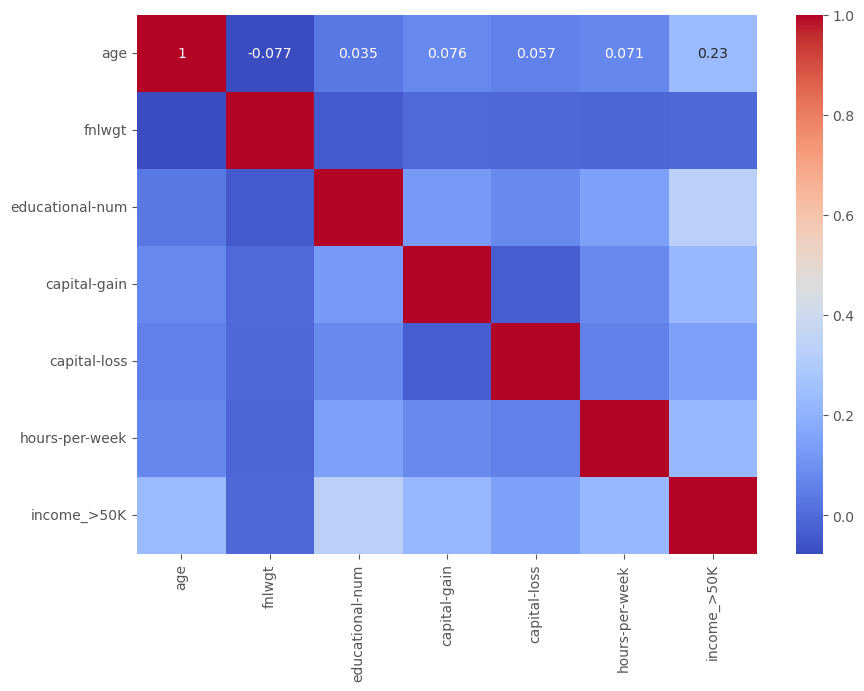

In [17]:
#################################################################################################################
#Correlation of Numeric Input Variables
#================================================================================================================

# Set the figure size for the heatmap
plt.rcParams['figure.figsize'] = [10, 7]

# Compute the correlation matrix for numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# None of the numeric input variables are well correlated, so they can be taken as independent predictors of the target variable.

# 3. Data Preparation

In [18]:
warnings.filterwarnings('ignore')

#################################################################################################################
# Define function for handling Outlier Vaslues in Numeric Columns Based on Quantile Analysis
#################################################################################################################

def handle_outliers(df, columns, f_handle):
    
    # Initialize lists to store the results
    lower_bounds = []
    upper_bounds = []
    outlier_cnts = []

    for i in columns:
        
        # Calculate IQR
        IQR = df[i].quantile(0.95) - df[i].quantile(0.05)
        lower_bound = np.round(df[i].quantile(0.05) - (1.5 * IQR),1)
        upper_bound = np.round(df[i].quantile(0.95) + (1.5 * IQR),1)
        
        # Calculate the number of outliers
        outliers = df[(df[i] < lower_bound) | (df[i] > upper_bound)]
        outlier_cnt = outliers.shape[0]
        
        # Print the bounds and the number of outliers
        print(f"{i:15}: LBound = {lower_bound:10}, UBound = {upper_bound:10}, Outliers = {outlier_cnt:10}")
        
        # Append the results to their respective lists
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
        outlier_cnts.append(outlier_cnt)

    print()
    if f_handle == True:
        j = 0
        for i in columns:
            df.loc[df[i] > upper_bounds[j], i] = int(upper_bounds[j])
            j = j + 1  

    # Optionally, return the lists of boundaries and counts
    return lower_bounds, upper_bounds, outlier_cnts

#================================================================================================================
# Clean the dataframe and then separate out Native-Born from Foreign-Born individuals
#================================================================================================================

df_cleaned = df

#----------------------------------------------------------------------------------------------------------------
# Eleminate rows from datset representing values that are under-represented in the dataset, as determined by EDA
#----------------------------------------------------------------------------------------------------------------

df_cleaned = df_cleaned[df_cleaned['age'           ] <= 75]
df_cleaned = df_cleaned[df_cleaned['hours-per-week'] <= 65]

#----------------------------------------------------------------------------------------------------------------
# Combine Capital Gain and Loss columns
#----------------------------------------------------------------------------------------------------------------

df_cleaned['capital-gain'] = df_cleaned['capital-gain'] - df_cleaned['capital-loss'] 
df_cleaned = df_cleaned.drop("capital-loss"   , axis=1)

#----------------------------------------------------------------------------------------------------------------
# Same data is already captured in the education column, so educational-num column can be dropped
#----------------------------------------------------------------------------------------------------------------

df_cleaned = df_cleaned.drop("educational-num", axis=1)

#----------------------------------------------------------------------------------------------------------------
# Remove columns created for temporary use above. We don't need the bracketed columns since we still have the
# original unbinned numeric columns for 'age' and 'hours-per-week'
#----------------------------------------------------------------------------------------------------------------

df_cleaned = df_cleaned.drop("age_bracket", axis=1)
df_cleaned = df_cleaned.drop("hpw_bracket", axis=1)
df_cleaned = df_cleaned.drop("hours-per-week_bracket", axis=1)

#----------------------------------------------------------------------------------------------------------------
# Compute the IQR and replace outlier values with the lower and upper bounds
#----------------------------------------------------------------------------------------------------------------

columns =  ["age", "hours-per-week"]
print(f"\n{'=' * 80}\nANALYSIS\n{'=' * 80}")
print("Before Quintile Processing...")
lower_boundries, upper_boundries, outlier_counts = handle_outliers(df_cleaned, columns, True )
print("After Quintile Processing...")
lower_boundries, upper_boundries, outlier_counts = handle_outliers(df_cleaned, columns, False)

#----------------------------------------------------------------------------------------------------------------
# Compensate for skewed histograms of numeric independent variables
#----------------------------------------------------------------------------------------------------------------
# Found that this didn't improve the analysis so commented out

#df_cleaned['log-age'              ] = np.log(df_cleaned['age'           ]+1)
#df_cleaned = df_cleaned.drop('age', axis=1)
#df_cleaned['log-hours-per-week'   ] = np.log(df_cleaned['hours-per-week']+1)
#df_cleaned = df_cleaned.drop('hours-per-week', axis=1)
#df_cleaned['log-fnlwgt'           ] = np.log(df_cleaned['fnlwgt'        ]+1)
#df_cleaned = df_cleaned.drop('fnlwgt', axis=1)

#----------------------------------------------------------------------------------------------------------------
# Drop dataset rows with missing values
#----------------------------------------------------------------------------------------------------------------

df_cleaned.dropna(inplace=True)

#----------------------------------------------------------------------------------------------------------------
# Aggregating all education classes representing less than a diploma, since the current differentiation does NOT
# provide information that helps to predict the likelihood of meeting the $50K threshold
#----------------------------------------------------------------------------------------------------------------

classes_to_aggregate = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th']
df_cleaned['education'] = df['education'].replace(classes_to_aggregate, '<HS')

#----------------------------------------------------------------------------------------------------------------
# Due to the dataset imbalance between native-born and foreign-born entries, we will look at separate models for
# each
#----------------------------------------------------------------------------------------------------------------

df_all     = df_cleaned
df_native  = df_cleaned.query("`native-country` == 'United-States'") # Evaluate Native-Born Individuals on their Own
df_foreign = df_cleaned.query("`native-country` != 'United-States'") # Evaluate Foriegn-Born Individuals on their Own

print(df_all.shape)
print(df_all['income_>50K'].value_counts())

print(df_native.shape)
print(df_native['income_>50K'].value_counts())

print(df_foreign.shape)
print(df_foreign['income_>50K'].value_counts())


ANALYSIS
Before Quintile Processing...
age            : LBound =      -45.5, UBound =      126.5, Outliers =          0
hours-per-week : LBound =      -45.0, UBound =      123.0, Outliers =          0

After Quintile Processing...
age            : LBound =      -45.5, UBound =      126.5, Outliers =          0
hours-per-week : LBound =      -45.0, UBound =      123.0, Outliers =          0

(39438, 13)
income_>50K
0    29755
1     9683
Name: count, dtype: int64
(35996, 13)
income_>50K
0    26951
1     9045
Name: count, dtype: int64
(3442, 13)
income_>50K
0    2804
1     638
Name: count, dtype: int64


In [19]:
df_cleaned.sample(10)

age     workclass  fnlwgt     education      marital-status  \
1629    35       Private  110013     Bachelors            Divorced   
8386    57     State-gov  141459  Some-college            Divorced   
21501   50       Private   38540       HS-grad  Married-civ-spouse   
6305    21     Local-gov  300812       HS-grad       Never-married   
41511   53       Private  175029       HS-grad  Married-civ-spouse   
15463   18       Private  264017  Some-college       Never-married   
19913   59       Private  159724       Masters  Married-civ-spouse   
21764   37  Self-emp-inc  317580       HS-grad  Married-civ-spouse   
18700   23       Private  320294       HS-grad       Never-married   
7813    29       Private  103432       HS-grad       Never-married   

            occupation   relationship   race  gender  capital-gain  \
1629     Other-service      Own-child  White  Female             0   
8386    Prof-specialty      Unmarried  White  Female             0   
21501  Exec-managerial        Husband  White    Male             0   
6305     Other-service      Own-child  White    Male             0   
41511  Exec-managerial        Husband  White    Male             0   
15463    Other-service      Own-child  White    Male             0   
19913            Sales        Husband  White    Male          7298   
21764     Craft-repair        Husband  White    Male             0   
18700  Exec-managerial  Not-in-family  White    Male             0   
7813      Craft-repair  Not-in-family  White    Male             0   

       hours-per-week native-country  income_>50K  
1629               40  United-States            0  
8386               40  United-States            0  
21501              40  United-States            0  
6305               40  United-States            0  
41511              50  United-States            1  
15463              16         Canada            0  
19913              55  United-States            1  
21764              40  United-States            0  
18700              40  United-States            0  
7813               40  United-States            0

# 4. Predictive Modeling / 5. Feature Importance

In [20]:
# Implement predictive modeling and feature importance analysis. This routine scales numeric columns and 
# encodes categorical columns via a pipepline. The dataset is then split into training and test sets.
# Oversampling is then applied to balance out the classes in the target variable, if desired, only when
# resample_ratio != -1 #is set in the run_models function. Finally, the code implements up to six different
# classifiers using GridSearchCV to determine the best Hyper-Parameters for each and reports the Feature
# Importances for each classifier based on the best parameters found for that classifier.

##############################################################################################################
# Function to Prepare the Data
##############################################################################################################

def prepare_data(df_in, target_column, resample_ratio):
    
    #=========================================================================================================
    # Split Target Variable from Independent Variables
    #=========================================================================================================
    
    X = df_in.drop(target_column, axis=1)
    y = df_in[target_column]
    
    #=========================================================================================================
    # Preprocessing Pipelines for Both Numeric and Categorical Data
    #=========================================================================================================

    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])
    preprocessor = ColumnTransformer([
        ('num', num_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', cat_transformer, X.select_dtypes(include=['object']).columns)])
    
    X_encoded = preprocessor.fit_transform(X)
    feature_names = get_feature_names(preprocessor)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
  
    print('Before resampling:\n', y_train.value_counts())

    if resample_ratio > 0:
        smote= SMOTETomek(sampling_strategy=resample_ratio)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    print('After resampling :\n', y_train.value_counts())

    return X_train, X_test, y_train, y_test, feature_names, preprocessor

##############################################################################################################
# Function to Retain Feature Names with OneHotEncoding
##############################################################################################################

def get_feature_names(column_transformer):
    
    output_features = []

    for transformer_info in column_transformer.transformers_:
        name, transformer, original_feature_names = transformer_info
        if name == 'remainder':
            if column_transformer.remainder == 'passthrough':
                remainder_cols = column_transformer.feature_names_in_  # If remainder='passthrough', include original column names
                output_features.extend([remainder_cols[i] for i in range(len(remainder_cols)) if i not in column_transformer._transformer_to_input_indices(name)])
            continue
        if hasattr(transformer, 'steps'):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer
        if hasattr(last_step, 'get_feature_names_out'):
            feature_names = last_step.get_feature_names_out(original_feature_names)  # Use the transformer's 'get_feature_names_out' method if available
        else:
            feature_names = original_feature_names                                   # Otherwise, use the original feature names directly
        output_features.extend(feature_names)
    
    return output_features

##############################################################################################################
# Function to Aggregate Feature Importances
##############################################################################################################

def aggregate_feature_importances(importances, feature_names, s):
    # Aggregate importances for original features
    aggregated_importances = {}
    for importance, feature_name in zip(importances, feature_names):
        original_feature = feature_name.split(s)[0]  # Splitting based on your OneHotEncoding naming convention
        if original_feature in aggregated_importances:
            aggregated_importances[original_feature] += np.abs(importance)  # Summing absolute importance for aggregated features
        else:
            aggregated_importances[original_feature] = np.abs(importance)
    return aggregated_importances

##############################################################################################################
# Function to Evaluate and Print Metrics of Model Performance
##############################################################################################################

def evaluate_predictions(y_test, y_scores, model_name, cutoff0, classes):

    cutoffs = [ 0.5, cutoff0 ]

    print('-' * 135)
    print('METRICS')

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(6, 5))

    for cutoff, ax in zip(cutoffs, axs):
        
        y_pred = (y_scores >= cutoff).astype(int)
    
        # Generating and plotting the Confusion Matrix on the specified subplot axis
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, classes, cutoff, ax=ax)  # Pass the subplot axis here
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the title
    plt.show()

    metrics_list = []
    for cutoff in cutoffs:
        y_pred = (y_scores >= cutoff).astype(int)
        accuracy  = accuracy_score (y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall    = recall_score   (y_test, y_pred)
        f1        = f1_score       (y_test, y_pred)
        metrics_list.append([cutoff, accuracy, precision, recall, f1])

    # Convert the list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list, columns=['Threshold','Accuracy','Precision','Recall','F1 Score'])

    display(metrics_df.set_index('Threshold').T)
    
##############################################################################################################
# Function to Plot the Confusion Matrix
##############################################################################################################

def plot_confusion_matrix(cm, classes, cutoff0, ax, norm=False):
    
    if norm:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    if norm: ax.set_title(f"Confusion Matrix (Normalized)\nthreshold = {cutoff0:.2f}")
    else:    ax.set_title(f"Confusion Matrix\nthreshold = {cutoff0:.2f}")
        
    ax.set_xticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(np.arange(len(classes)))
    ax.set_yticklabels(classes)
    
    ax.grid(False)
    
    fmt = '.2f' if norm else 'd'
    cutoff = cm.max() / 2.
    
    outcome_labels = [['TN', 'FP'], ['FN', 'TP']]
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        cell_label = outcome_labels[i][j]
        ax.text(j, i, f"{cell_label} \n({format(cm[i, j], fmt)})",
                ha='center', va='center',
                color='white' if cm[i, j] > cutoff else 'black')
        
    ax.set_ylabel('Actual'   )
    ax.set_xlabel('Predicted')
    
##############################################################################################################
# Neural Network Model Function
##############################################################################################################

def create_model(input_dim, layers=[64, 64], activation='relu', optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, activation=activation))
    for units in layers[1:]:
        model.add(Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['Accuracy'])
    return model

##############################################################################################################
# Function to implement Informedness Scoring
##############################################################################################################

def informedness_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr - fpr
    
##############################################################################################################
# Function to implement G-Means Scoring
##############################################################################################################

def gmeans_score(y_true, y_scores, **kwargs):
    # Calculate the False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    # Calculate G-Means
    gmeans = np.sqrt(tpr * (1 - fpr))
    # Find the maximum G-Means score
    max_gmeans = np.max(gmeans)
    return max_gmeans

##############################################################################################################
# Function to Calculate Accuracy between Predictions and Actuals
##############################################################################################################

def acc_scores(cutoffs, y_scores, y_test):
    scores = []
    for cutoff in cutoffs:
        y_pred   = y_scores >= cutoff
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)
    return scores
    
##############################################################################################################
# Function to Implement Encoding, Model Fit, and Provide Feature Importances
##############################################################################################################

def run_models(df_in, target_col, model_select, resample_ratio=-1, scoring_method='f1'):

    X_train, X_test, y_train, y_test, feature_names, preprocessor = prepare_data(df_in, target_col, resample_ratio)

    #=========================================================================================================
    # Hyper-Parameters for GridSearch
    #=========================================================================================================

    classifiers = {'LogReg'    : { 'model' : LogisticRegression    ( solver='liblinear'     )  ,
                                   'params': {'C'                  : 10.0 ** np.arange(-2, 3)  ,
                                              'penalty'            : ['l1', 'l2'              ]}}
                   ,
                   'KNN'       : { 'model' : KNeighborsClassifier  (),
                                   'params': {'n_neighbors'        : [3, 5, 7, 10             ],
                                              'metric'             : ['euclidean', 'manhattan'],
                                              'weights'            : ['uniform'  , 'distance' ]}}
                   ,
                   'DecTree'   : { 'model' : DecisionTreeClassifier(),
                                   'params': {'max_depth'          : [None, 5, 10, 15, 20, 30 ],
                                              'min_samples_leaf'   : [1, 2, 4                 ],
                                              'min_samples_split'  : [2, 5, 10                ]}}
                   ,
                   'RndForest' : { 'model' : RandomForestClassifier(),
                                   'params': {'n_estimators'       : [10, 50, 100             ],
                                              'max_depth'          : [None, 5, 10, 15, 20     ],
                                              'min_samples_leaf'   : [1, 2, 4                 ],
                                              'min_samples_split'  : [2, 5, 10                ]}}
                   ,
                   'NeuralNet' : { 'model' : KerasClassifier       ( build_fn=create_model, 
                                                                     input_dim=X_train.shape[1], 
                                                                     layers=[32, 32], 
                                                                     activation='relu',
                                                                     optimizer='adam', 
                                                                     dropout_rate=0.0),
                                   'params': {'epochs'             : [20, 30                  ],
                                              'batch_size'         : [16, 32                  ],
                                              'layers'             : [[64, 64], [64, 64, 32]  ],
                                              'optimizer'          : ['adam', 'rmsprop'       ],
                                              'dropout_rate'       : [0.0, 0.2                ]}}
                   ,
                   'SVM'       : { 'model' : SVC(),
                                   'params': {'C'                  : [0.1, 1, 10, 100         ],
                                              'kernel'             : ['linear', 'rbf'         ],
                                              'gamma'              : ['scale', 'auto'         ]}}
                  }

    classifier_keys = list(classifiers.keys())
    f_inc_classifier = [model_name in model_select for model_name in classifier_keys]

    #=========================================================================================================
    # Loop through classifiers to Implement Gridsearch and Feature Importance Analysis for Each
    #=========================================================================================================

    param1_list   = []
    param2_list   = []
    param3_list   = []
    model_names   = []
    best_cutoffs  = []
    ixs           = []

    # Lists defining which metrics belong to ROC or PR curve analysis.
    ROC_list = ['informedness', 'gmeans', 'accuracy', 'roc_auc']
    PR_list  = ['f1', 'precision', 'recall', 'average_precision']

    for i, run_model in enumerate(f_inc_classifier):

        if run_model == True:
            
            name = classifier_keys[i]
            info = classifiers[name]

            print(f"\n{'#' * 135}\nTraining {name}\n{'#' * 135}")

            #-------------------------------------------------------------------------------------------------
            # Implement GridSearchCV
            #-------------------------------------------------------------------------------------------------

            method = scoring_method
            if   scoring_method == 'informedness' : method = make_scorer(informedness_score)
            elif scoring_method == 'gmeans'       : method = make_scorer(gmeans_score, needs_threshold=True)
            elif scoring_method not in ['f1', 'accuracy', 'precision', 'recall', 'roc_auc', 'average_precision']:
                raise ValueError('Unsupported scoring method')
                
            start_time = time.time()  # Start timing
            gridsearch = GridSearchCV(info['model'], info['params'], cv=5, scoring=method, n_jobs=-1, verbose=2)
            gridsearch.fit(X_train, y_train)
            duration   = time.time() - start_time
    
            #-------------------------------------------------------------------------------------------------
            # Provide Evaluation of Performance for Best Model
            #-------------------------------------------------------------------------------------------------

            y_pred = gridsearch.predict(X_test)       # Make predictions on the test set

            print(f'Classification Report for {name} using best parameters:\n{classification_report(y_test, y_pred)}')
            print("-" * 135)
            print(f"Best parameters for {name}: {gridsearch.best_params_}")
            print(f"Best Training Score for {name}: {gridsearch.best_score_}")
            print(f"Training duration: {duration:.2f} seconds")
            print()

            #-------------------------------------------------------------------------------------------------
            # Determine ROC / PR Curves
            #-------------------------------------------------------------------------------------------------

            if hasattr(gridsearch.best_estimator_  , 'predict_proba'    ):
                y_scores = gridsearch.predict_proba(X_test)[:, 1]
            elif hasattr(gridsearch.best_estimator_, 'decision_function'):
                y_scores = gridsearch.decision_function(X_test)
            else:
                raise RuntimeError('The estimator does not have a predict_proba or decision_function method.')

            if scoring_method in ROC_list:
                
                fpr, tpr, cutoffs = roc_curve(y_test, y_scores)
                auc_vals = auc(fpr, tpr)

                if   scoring_method == 'informedness': ix = np.argmax(tpr - fpr                            )
                elif scoring_method == 'gmeans'      : ix = np.argmax(np.sqrt(tpr * (1-fpr))               )
                elif scoring_method == 'roc_auc'     : ix = np.argmax(auc_vals                             )
                else                                 : ix = np.argmax(acc_scores(cutoffs, y_scores, y_test))

                param1_list.append(fpr          )
                param2_list.append(tpr          )
                param3_list.append(auc_vals     )

            elif scoring_method in PR_list:
                
                precision, recall, cutoffs = precision_recall_curve(y_test, y_scores)
                avg_precision = average_precision_score(y_test, y_scores)
                
                if   scoring_method == 'precision'        : ix = np.argmax(precision                       )
                elif scoring_method == 'recall'           : ix = np.argmax(recall                          )
                elif scoring_method == 'average_precision': ix = np.argmax(avg_precision                   )
                else: ix = np.argmax((2 * precision * recall) / (precision + recall + 1e-10)               )
                
                param1_list.append(precision    )
                param2_list.append(recall       )
                param3_list.append(avg_precision)

            else:
                
                raise ValueError('Unsupported scoring method')

            best_cutoff = cutoffs[ix]
            
            ixs.append(ix)
            model_names.append(name)
    
            evaluate_predictions(y_test, y_scores, name, best_cutoff, ['<=$50K', '>$50K'])

            #-------------------------------------------------------------------------------------------------
            # Plot Feature Importances
            #-------------------------------------------------------------------------------------------------

            best_model = gridsearch.best_estimator_
            feature_names = get_feature_names(preprocessor)  # Extract feature names
    
            if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
                importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else best_model.coef_[0]
                aggregated_importances = aggregate_feature_importances(importances, feature_names,'_')
        
                # Sort Features by Importance
                sorted_features = sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True)
                sorted_feature_names, sorted_importances = zip(*sorted_features)
        
                plt.figure(figsize=(9, 3))
                plt.title(f'Aggregated Feature Importances for {name}')
                plt.bar(range(len(sorted_feature_names)), sorted_importances, align='center')
                plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=45, ha='right')
                plt.tight_layout()
                plt.show()

    #=========================================================================================================
    # Plot Aggregated ROC / PR Curves
    #=========================================================================================================
    
    plt.figure(figsize=(5, 4))

    if scoring_method in ROC_list:
        str_area = 'AUC'
        plt.xlabel('False Positive Rate'); 
        plt.ylabel('True Positive Rate' )
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle='--')
    elif scoring_method in PR_list:
        str_area = 'Avg. Prec.'
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
    else:
        str_area = 'Metric'
        
    for i, name in enumerate(model_names):
        plt.plot(param1_list[i], param2_list[i], lw=2, label=f'{str_area} = {param3_list[i]:.2f} : {name}')
        ix = ixs[i]
        plt.scatter(param1_list[i][ix], param2_list[i][ix], s=50, marker='o', color='black', zorder=5)

    plt.xlim([0.00, 1.00])
    plt.ylim([0.00, 1.00])
    plt.legend(loc='best')
    plt.show()


Before resampling:
 income_>50K
0    23769
1     7781
Name: count, dtype: int64
After resampling :
 income_>50K
0    23769
1     7781
Name: count, dtype: int64

#######################################################################################################################################
Training LogReg
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogReg using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5986
           1       0.71      0.60      0.65      1902

    accuracy                           0.85      7888
   macro avg       0.80      0.76      0.78      7888
weighted avg       0.84      0.85      0.84      7888

-----------------------------------------------------------------------------------------------------------

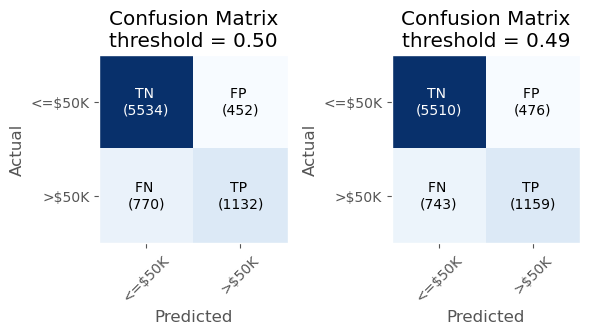

Threshold  0.500000  0.486625
Accuracy   0.845081  0.845461
Precision  0.714646  0.708869
Recall     0.595163  0.609359
F1 Score   0.649455  0.655358

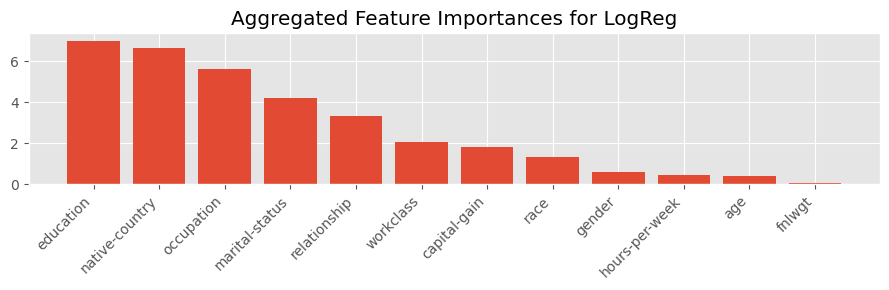


#######################################################################################################################################
Training KNN
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNN using best parameters:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5986
           1       0.72      0.54      0.62      1902

    accuracy                           0.84      7888
   macro avg       0.79      0.74      0.76      7888
weighted avg       0.83      0.84      0.83      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Best Training Score for KNN: 0.8377812995245643

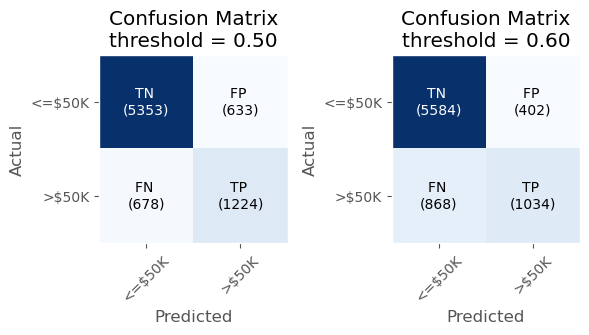

Threshold       0.5       0.6
Accuracy   0.833798  0.838996
Precision  0.659128  0.720056
Recall     0.643533  0.543638
F1 Score   0.651237  0.619533


#######################################################################################################################################
Training DecTree
#######################################################################################################################################
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Classification Report for DecTree using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5986
           1       0.75      0.60      0.67      1902

    accuracy                           0.85      7888
   macro avg       0.81      0.77      0.79      7888
weighted avg       0.85      0.85      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for DecTree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Training Score for DecTree: 

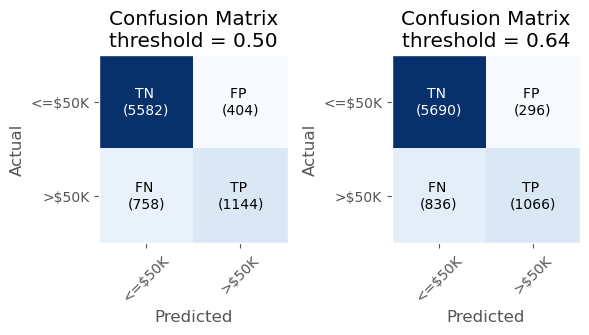

Threshold  0.500000  0.642857
Accuracy   0.852688  0.856491
Precision  0.739018  0.782673
Recall     0.601472  0.560463
F1 Score   0.663188  0.653186

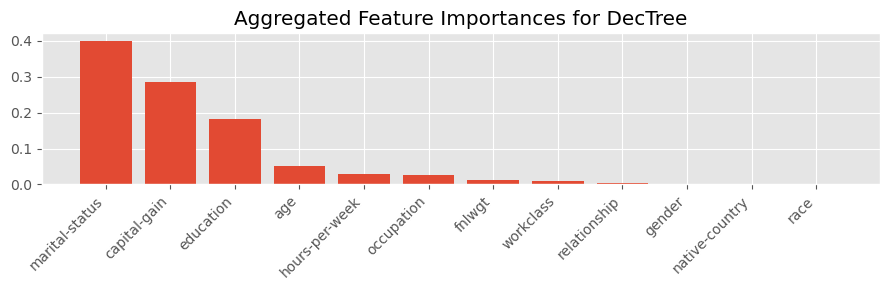


#######################################################################################################################################
Training RndForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RndForest using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5986
           1       0.76      0.61      0.68      1902

    accuracy                           0.86      7888
   macro avg       0.82      0.77      0.79      7888
weighted avg       0.85      0.86      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RndForest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best

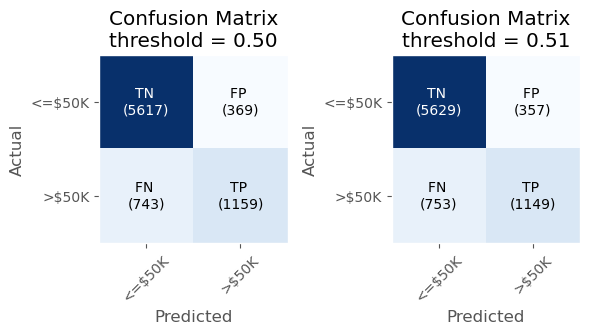

Threshold  0.500000  0.506205
Accuracy   0.859026  0.859280
Precision  0.758508  0.762948
Recall     0.609359  0.604101
F1 Score   0.675802  0.674296

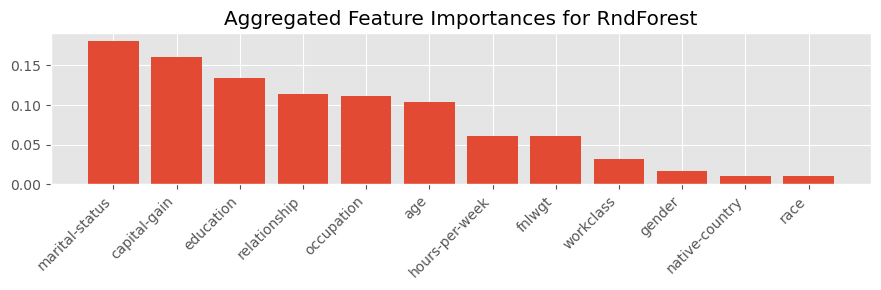


#######################################################################################################################################
Training NeuralNet
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/20
986/986 [==============================] - 1s 720us/step - loss: 0.3408 - Accuracy: 0.8404
Epoch 2/20
986/986 [==============================] - 1s 719us/step - loss: 0.3144 - Accuracy: 0.8542
Epoch 3/20
986/986 [==============================] - 1s 716us/step - loss: 0.3076 - Accuracy: 0.8585
Epoch 4/20
986/986 [==============================] - 1s 724us/step - loss: 0.3025 - Accuracy: 0.8620
Epoch 5/20
986/986 [==============================] - 1s 728us/step - loss: 0.2991 - Accuracy: 0.8620
Epoch 6/20
986/986 [==============================] - 1s 710us/step - loss: 0.2961 - Accuracy: 0.8641
Epoch 7/20
986/986 [==============

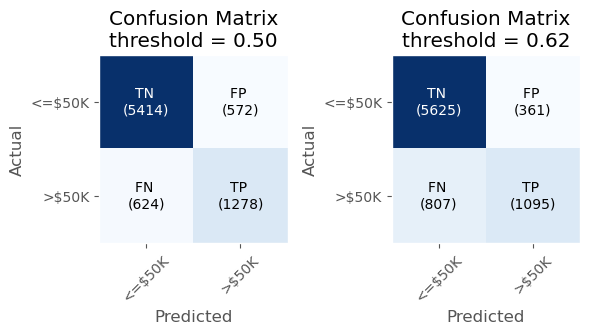

Threshold  0.500000  0.623899
Accuracy   0.848377  0.851927
Precision  0.690811  0.752060
Recall     0.671924  0.575710
F1 Score   0.681237  0.652174


#######################################################################################################################################
Training SVM
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for SVM using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      5986
           1       0.74      0.59      0.66      1902

    accuracy                           0.85      7888
   macro avg       0.81      0.76      0.78      7888
weighted avg       0.85      0.85      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Score for SVM: 0.8560697305863709
Training duration: 5

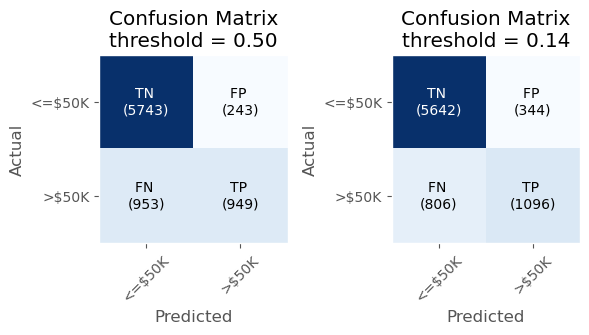

Threshold  0.500000  0.137504
Accuracy   0.848377  0.854209
Precision  0.796141  0.761111
Recall     0.498948  0.576236
F1 Score   0.613445  0.655895

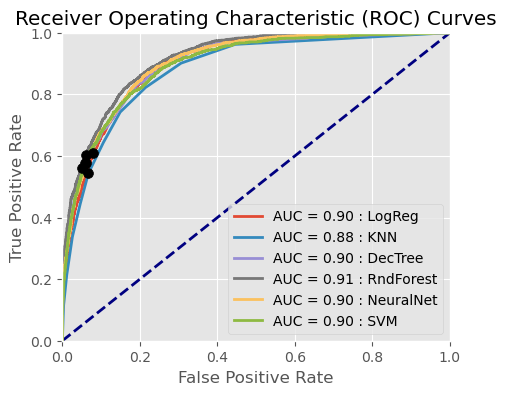

In [21]:
#RUN ANALYSIS #1: NATIVE- AND FOREIGN-BORN INDIVIDUALS W/ MODELS SCORED ON ACCURACY FOR ORIGINAL UNBALANCED DATSET

target_col     = "income_>50K"
model_select   = [ 'LogReg', 'KNN', 'DecTree', 'RndForest', 'NeuralNet', 'SVM' ]
resample_ratio = -1
scoring_method = "accuracy" # Can be: accuracy, gmeans, informedness, roc_auc, f1, precision, recall, average_precision

run_models(df_all, target_col, model_select, resample_ratio, scoring_method)

Before resampling:
 income_>50K
0    23769
1     7781
Name: count, dtype: int64
After resampling :
 income_>50K
0    22969
1    17026
Name: count, dtype: int64

#######################################################################################################################################
Training LogReg
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogReg using best parameters:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      5986
           1       0.60      0.79      0.68      1902

    accuracy                           0.82      7888
   macro avg       0.76      0.81      0.78      7888
weighted avg       0.85      0.82      0.83      7888

-----------------------------------------------------------------------------------------------------------

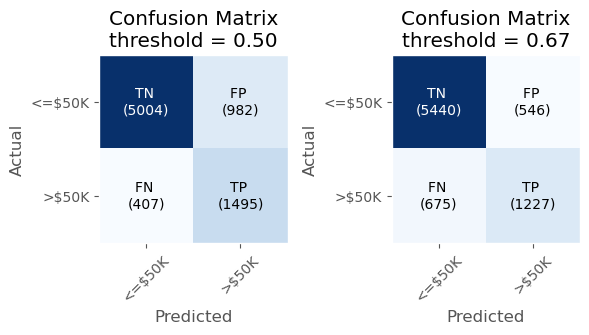

Threshold  0.500000  0.674985
Accuracy   0.823910  0.845208
Precision  0.603553  0.692047
Recall     0.786015  0.645110
F1 Score   0.682804  0.667755

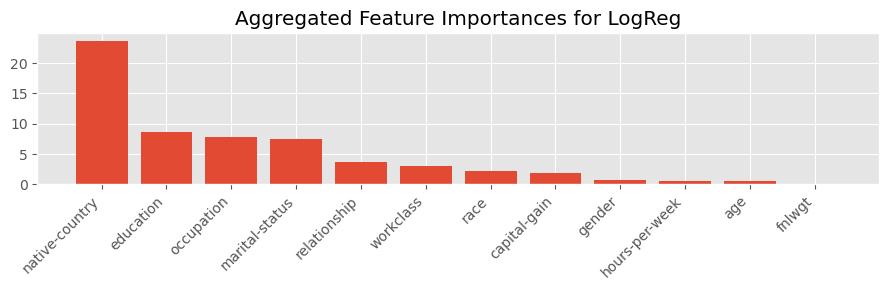


#######################################################################################################################################
Training KNN
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNN using best parameters:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5986
           1       0.56      0.70      0.62      1902

    accuracy                           0.80      7888
   macro avg       0.73      0.76      0.74      7888
weighted avg       0.82      0.80      0.80      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Training Score for KNN: 0.8897112139017377

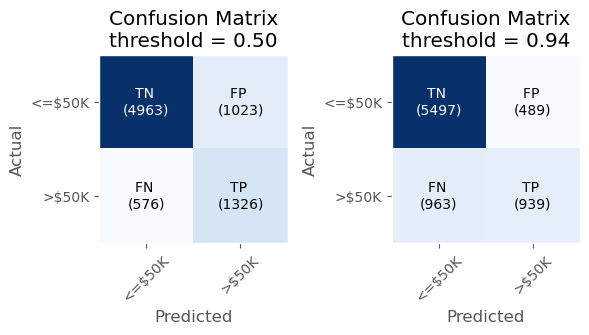

Threshold  0.500000  0.935665
Accuracy   0.797287  0.815923
Precision  0.564496  0.657563
Recall     0.697161  0.493691
F1 Score   0.623853  0.563964


#######################################################################################################################################
Training DecTree
#######################################################################################################################################
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Classification Report for DecTree using best parameters:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      5986
           1       0.58      0.76      0.66      1902

    accuracy                           0.81      7888
   macro avg       0.75      0.79      0.76      7888
weighted avg       0.84      0.81      0.82      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for DecTree: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Training Score for DecTree: 0

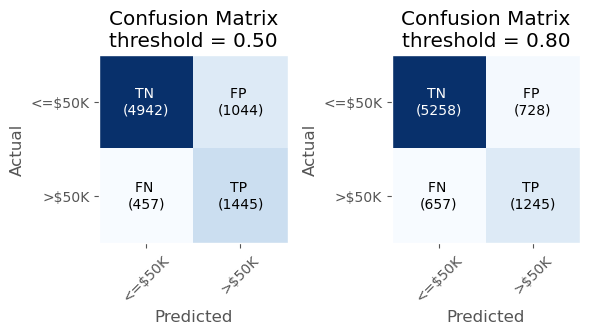

Threshold  0.500000  0.796253
Accuracy   0.809711  0.824417
Precision  0.580554  0.631019
Recall     0.759727  0.654574
F1 Score   0.658164  0.642581

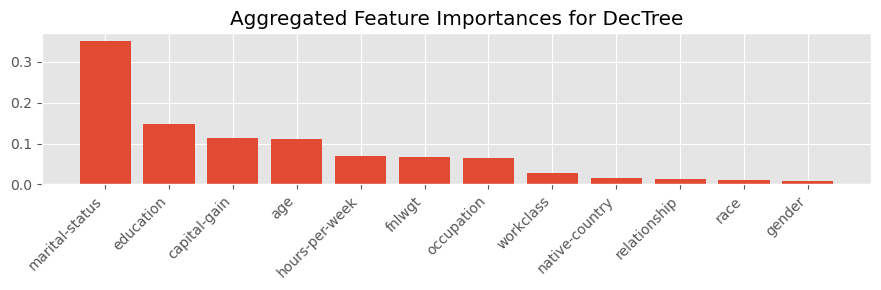


#######################################################################################################################################
Training RndForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RndForest using best parameters:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5986
           1       0.68      0.67      0.67      1902

    accuracy                           0.84      7888
   macro avg       0.79      0.79      0.79      7888
weighted avg       0.84      0.84      0.84      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RndForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best

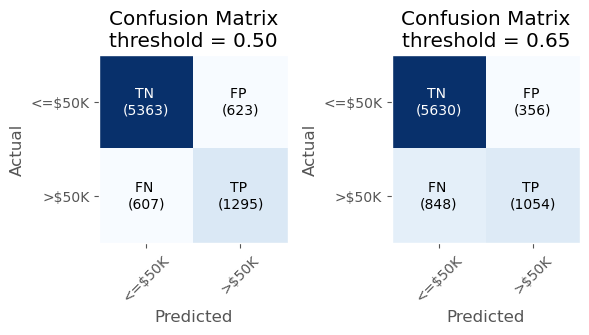

Threshold  0.500000  0.653333
Accuracy   0.844067  0.847363
Precision  0.675182  0.747518
Recall     0.680862  0.554154
F1 Score   0.678010  0.636473

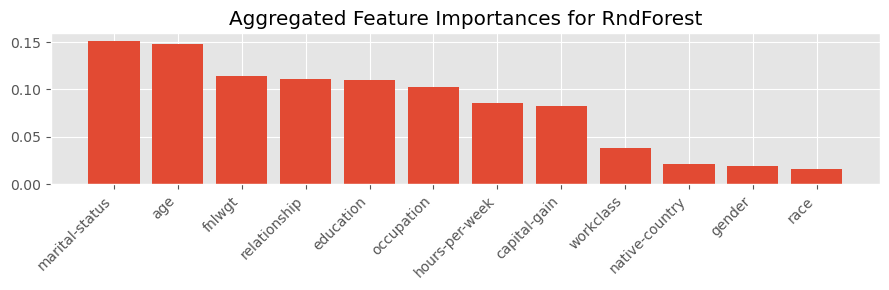


#######################################################################################################################################
Training NeuralNet
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/30
2500/2500 [==============================] - 2s 673us/step - loss: 0.3543 - Accuracy: 0.8355
Epoch 2/30
2500/2500 [==============================] - 2s 628us/step - loss: 0.3295 - Accuracy: 0.8466
Epoch 3/30
2500/2500 [==============================] - 2s 635us/step - loss: 0.3183 - Accuracy: 0.8522
Epoch 4/30
2500/2500 [==============================] - 2s 646us/step - loss: 0.3077 - Accuracy: 0.8601
Epoch 5/30
2500/2500 [==============================] - 2s 646us/step - loss: 0.2990 - Accuracy: 0.8639
Epoch 6/30
2500/2500 [==============================] - 2s 645us/step - loss: 0.2904 - Accuracy: 0.8688
Epoch 7/30
2500/2500 [

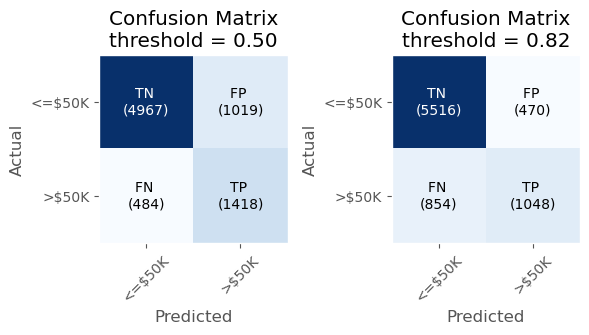

Threshold  0.500000  0.821315
Accuracy   0.809457  0.832150
Precision  0.581863  0.690382
Recall     0.745531  0.550999
F1 Score   0.653607  0.612865


#######################################################################################################################################
Training SVM
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for SVM using best parameters:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      5986
           1       0.60      0.73      0.66      1902

    accuracy                           0.82      7888
   macro avg       0.76      0.79      0.77      7888
weighted avg       0.83      0.82      0.82      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for SVM: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Score for SVM: 0.8737592199024877
Training duration:

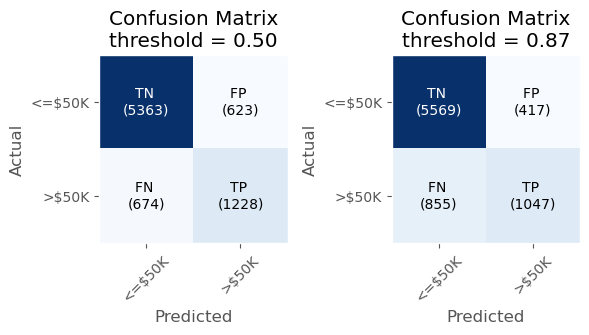

Threshold  0.500000  0.866822
Accuracy   0.835573  0.838742
Precision  0.663425  0.715164
Recall     0.645636  0.550473
F1 Score   0.654410  0.622103

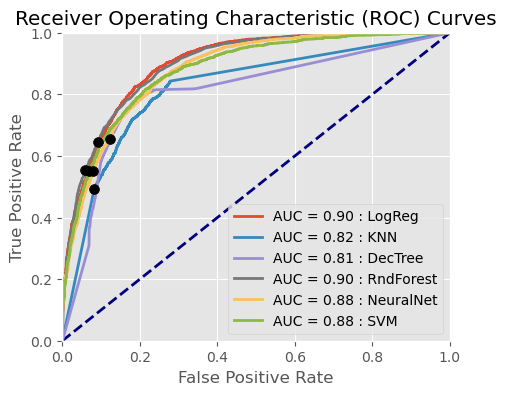

In [22]:
#RUN ANALYSIS #1: NATIVE- AND FOREIGN-BORN INDIVIDUALS W/ MODELS SCORED ON ACCURACY FOR RE-BALANCED DATASET TO MINORITY/MAJORITY = 0.75

target_col     = "income_>50K"
model_select   = [ 'LogReg', 'KNN', 'DecTree', 'RndForest', 'NeuralNet', 'SVM' ]
resample_ratio = 0.75
scoring_method = "accuracy" # Can be: accuracy, gmeans, informedness, roc_auc, f1, precision, recall, average_precision

run_models(df_all, target_col, model_select, resample_ratio, scoring_method)

Before resampling:
 income_>50K
0    23769
1     7781
Name: count, dtype: int64
After resampling :
 income_>50K
1    23074
0    23074
Name: count, dtype: int64

#######################################################################################################################################
Training LogReg
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogReg using best parameters:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      5986
           1       0.57      0.83      0.67      1902

    accuracy                           0.81      7888
   macro avg       0.75      0.81      0.77      7888
weighted avg       0.85      0.81      0.82      7888

-----------------------------------------------------------------------------------------------------------

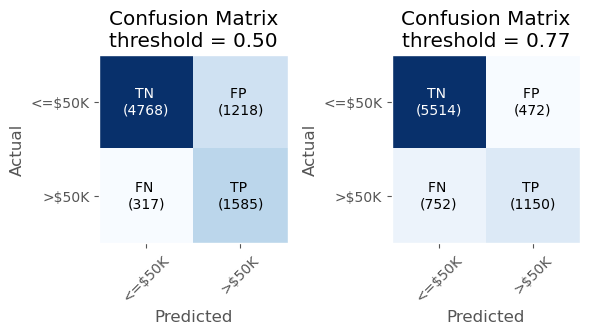

Threshold  0.500000  0.772384
Accuracy   0.805401  0.844828
Precision  0.565466  0.709001
Recall     0.833333  0.604627
F1 Score   0.673751  0.652667

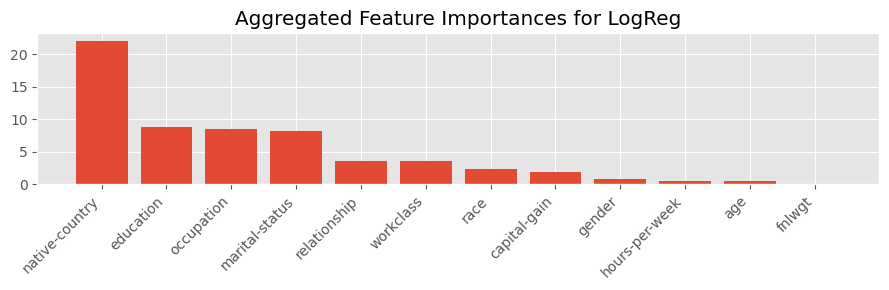


#######################################################################################################################################
Training KNN
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNN using best parameters:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      5986
           1       0.55      0.71      0.62      1902

    accuracy                           0.79      7888
   macro avg       0.72      0.76      0.74      7888
weighted avg       0.81      0.79      0.80      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Training Score for KNN: 0.9004725389267684

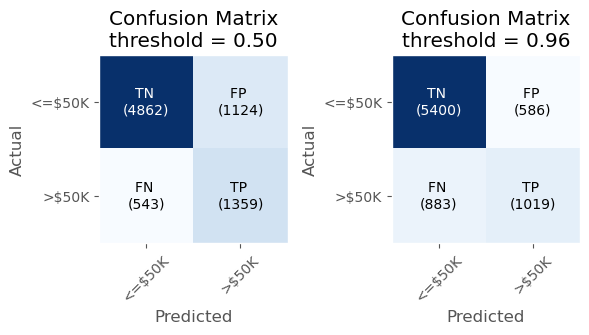

Threshold  0.500000  0.961328
Accuracy   0.788666  0.813768
Precision  0.547322  0.634891
Recall     0.714511  0.535752
F1 Score   0.619840  0.581123


#######################################################################################################################################
Training DecTree
#######################################################################################################################################
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Classification Report for DecTree using best parameters:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      5986
           1       0.58      0.76      0.66      1902

    accuracy                           0.81      7888
   macro avg       0.75      0.79      0.76      7888
weighted avg       0.84      0.81      0.82      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for DecTree: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Training Score for DecTree: 0

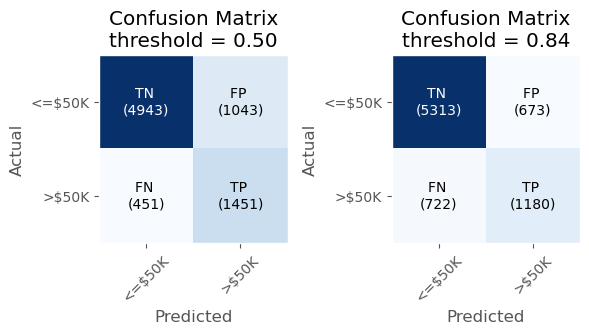

Threshold  0.500000  0.837795
Accuracy   0.810598  0.823149
Precision  0.581796  0.636805
Recall     0.762881  0.620400
F1 Score   0.660146  0.628495

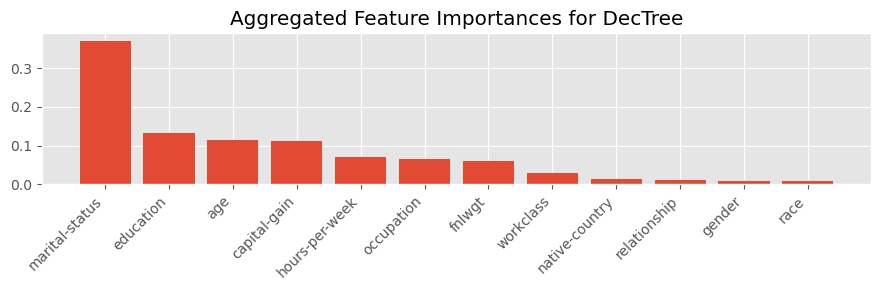


#######################################################################################################################################
Training RndForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RndForest using best parameters:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5986
           1       0.66      0.69      0.68      1902

    accuracy                           0.84      7888
   macro avg       0.78      0.79      0.79      7888
weighted avg       0.84      0.84      0.84      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RndForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best

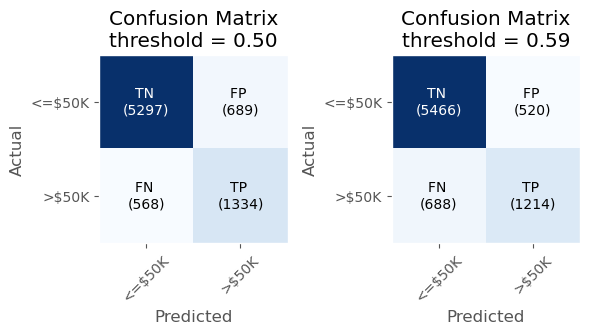

Threshold      0.50      0.59
Accuracy   0.840644  0.846856
Precision  0.659417  0.700115
Recall     0.701367  0.638275
F1 Score   0.679745  0.667767

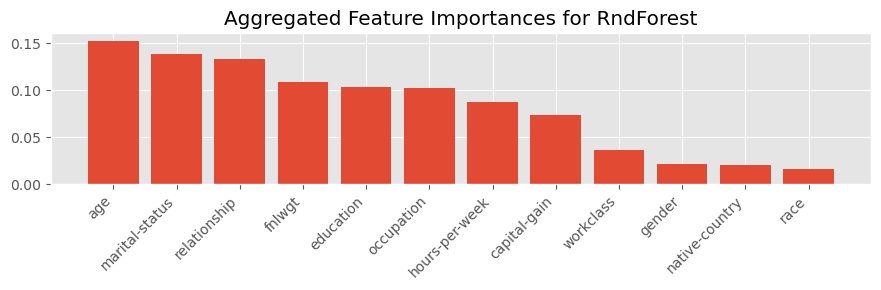


#######################################################################################################################################
Training NeuralNet
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/30
2885/2885 [==============================] - 2s 693us/step - loss: 0.3509 - Accuracy: 0.8429
Epoch 2/30
2885/2885 [==============================] - 2s 645us/step - loss: 0.3233 - Accuracy: 0.8557
Epoch 3/30
2885/2885 [==============================] - 2s 650us/step - loss: 0.3100 - Accuracy: 0.8613
Epoch 4/30
2885/2885 [==============================] - 2s 637us/step - loss: 0.2985 - Accuracy: 0.8686
Epoch 5/30
2885/2885 [==============================] - 2s 636us/step - loss: 0.2881 - Accuracy: 0.8753
Epoch 6/30
2885/2885 [==============================] - 2s 657us/step - loss: 0.2789 - Accuracy: 0.8796
Epoch 7/30
2885/2885 [

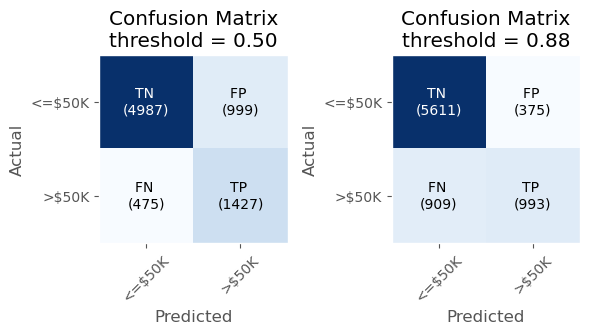

Threshold  0.500000  0.875571
Accuracy   0.813134  0.837221
Precision  0.588211  0.725877
Recall     0.750263  0.522082
F1 Score   0.659427  0.607339


#######################################################################################################################################
Training SVM
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for SVM using best parameters:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      5986
           1       0.59      0.75      0.66      1902

    accuracy                           0.81      7888
   macro avg       0.75      0.79      0.77      7888
weighted avg       0.84      0.81      0.82      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for SVM: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Score for SVM: 0.8844161163753569
Training duration:

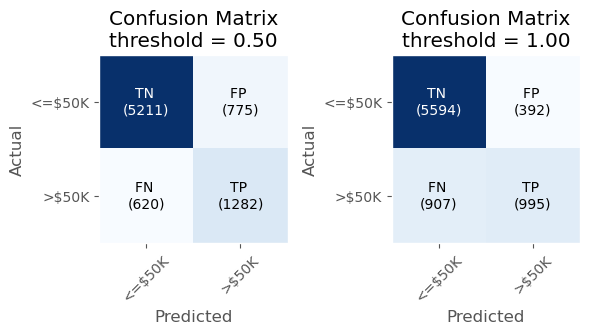

Threshold  0.500000  0.998851
Accuracy   0.823149  0.835319
Precision  0.623238  0.717376
Recall     0.674027  0.523134
F1 Score   0.647638  0.605047

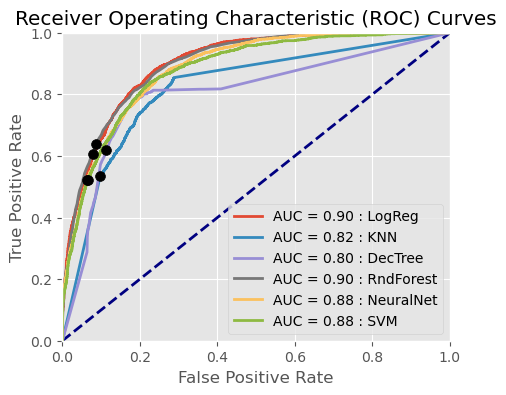

In [23]:
#RUN ANALYSIS #1: NATIVE- AND FOREIGN-BORN INDIVIDUALS W/ MODELS SCORED ON ACCURACY FOR RE-BALANCED DATASET TO MINORITY/MAJORITY = 1.0

target_col     = "income_>50K"
model_select   = [ 'LogReg', 'KNN', 'DecTree', 'RndForest', 'NeuralNet', 'SVM' ]
resample_ratio = 1.0
scoring_method = "accuracy" # Can be: accuracy, gmeans, informedness, roc_auc, f1, precision, recall, average_precision

run_models(df_all, target_col, model_select, resample_ratio, scoring_method)

Before resampling:
 income_>50K
0    23769
1     7781
Name: count, dtype: int64
After resampling :
 income_>50K
0    23769
1     7781
Name: count, dtype: int64

#######################################################################################################################################
Training LogReg
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogReg using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5986
           1       0.71      0.60      0.65      1902

    accuracy                           0.84      7888
   macro avg       0.79      0.76      0.77      7888
weighted avg       0.84      0.84      0.84      7888

-----------------------------------------------------------------------------------------------------------

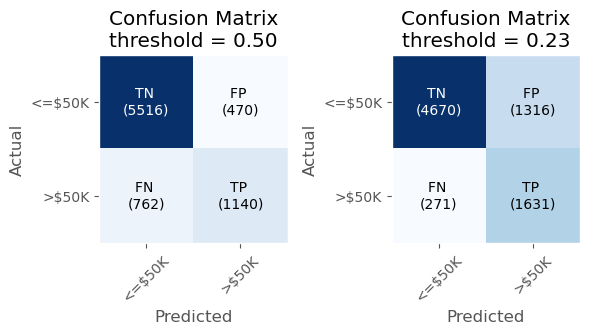

Threshold  0.500000  0.227969
Accuracy   0.843813  0.798808
Precision  0.708075  0.553444
Recall     0.599369  0.857518
F1 Score   0.649203  0.672716

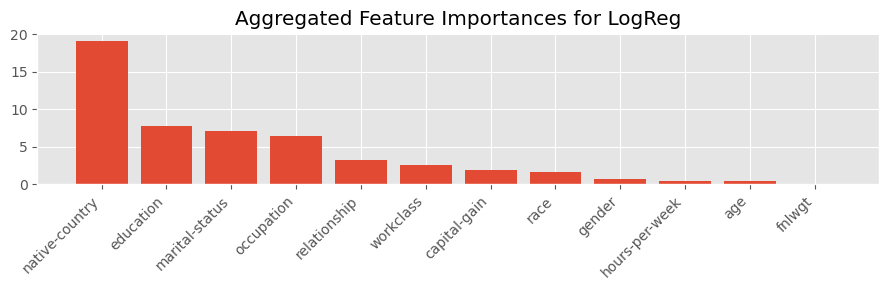


#######################################################################################################################################
Training KNN
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNN using best parameters:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5986
           1       0.72      0.54      0.62      1902

    accuracy                           0.84      7888
   macro avg       0.79      0.74      0.76      7888
weighted avg       0.83      0.84      0.83      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Best Training Score for KNN: 0.8031151545401987

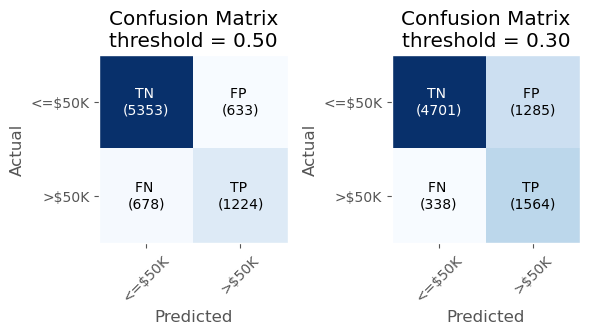

Threshold       0.5       0.3
Accuracy   0.833798  0.794244
Precision  0.659128  0.548965
Recall     0.643533  0.822292
F1 Score   0.651237  0.658388


#######################################################################################################################################
Training DecTree
#######################################################################################################################################
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Classification Report for DecTree using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5986
           1       0.74      0.59      0.66      1902

    accuracy                           0.85      7888
   macro avg       0.81      0.76      0.78      7888
weighted avg       0.85      0.85      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for DecTree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Training Score for DecTree: 

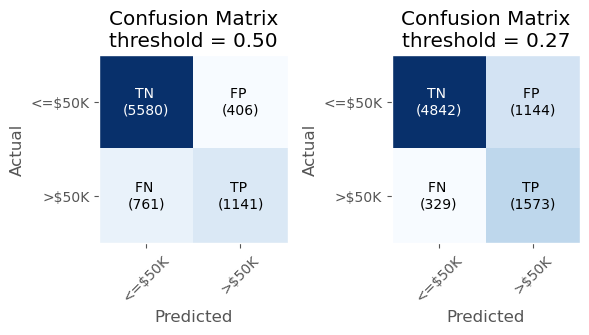

Threshold  0.500000  0.265306
Accuracy   0.852054  0.813261
Precision  0.737557  0.578947
Recall     0.599895  0.827024
F1 Score   0.661641  0.681100

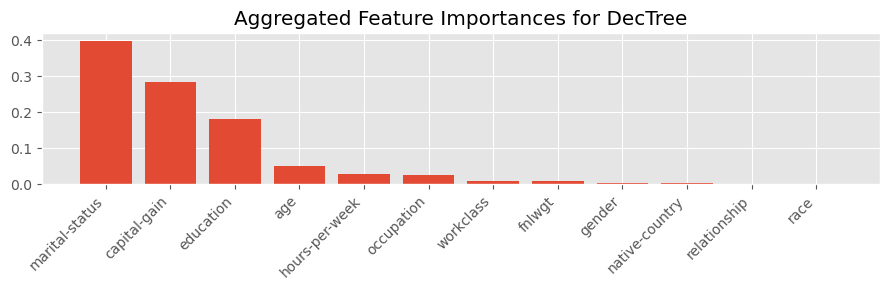


#######################################################################################################################################
Training RndForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RndForest using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5986
           1       0.77      0.60      0.67      1902

    accuracy                           0.86      7888
   macro avg       0.82      0.77      0.79      7888
weighted avg       0.85      0.86      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RndForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best 

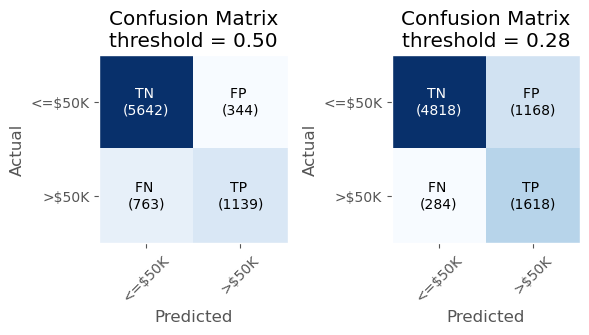

Threshold  0.500000  0.277441
Accuracy   0.859660  0.815923
Precision  0.768038  0.580761
Recall     0.598843  0.850683
F1 Score   0.672969  0.690273

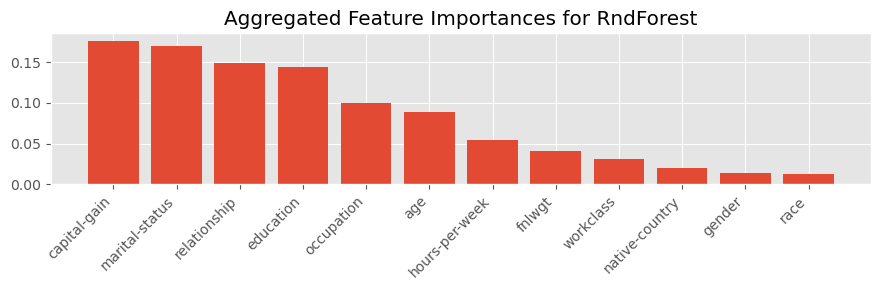


#######################################################################################################################################
Training NeuralNet
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/20
986/986 [==============================] - 1s 749us/step - loss: 0.3433 - Accuracy: 0.8392
Epoch 2/20
986/986 [==============================] - 1s 762us/step - loss: 0.3171 - Accuracy: 0.8519
Epoch 3/20
986/986 [==============================] - 1s 744us/step - loss: 0.3104 - Accuracy: 0.8566
Epoch 4/20
986/986 [==============================] - 1s 753us/step - loss: 0.3040 - Accuracy: 0.8603
Epoch 5/20
986/986 [==============================] - 1s 741us/step - loss: 0.2997 - Accuracy: 0.8638
Epoch 6/20
986/986 [==============================] - 1s 762us/step - loss: 0.2971 - Accuracy: 0.8632
Epoch 7/20
986/986 [==============

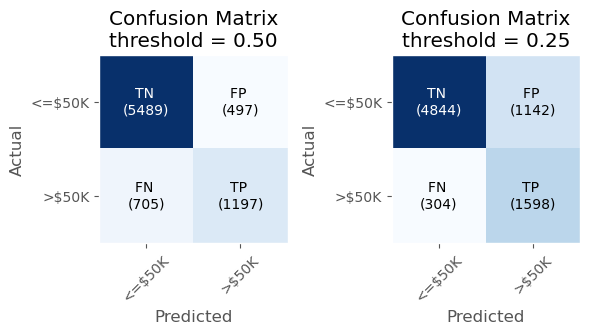

Threshold  0.500000  0.247733
Accuracy   0.847617  0.816684
Precision  0.706612  0.583212
Recall     0.629338  0.840168
F1 Score   0.665740  0.688496


#######################################################################################################################################
Training SVM
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for SVM using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      5986
           1       0.74      0.59      0.66      1902

    accuracy                           0.85      7888
   macro avg       0.81      0.76      0.78      7888
weighted avg       0.84      0.85      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Training Score for SVM: 0.824097546455549
Training duration: 56

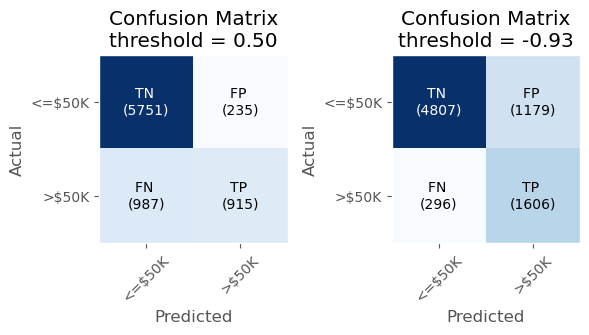

Threshold    0.5000   -0.9343
Accuracy   0.845081  0.813007
Precision  0.795652  0.576661
Recall     0.481073  0.844374
F1 Score   0.599607  0.685300

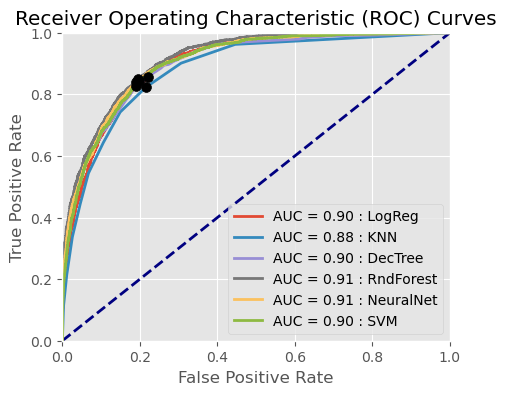

In [24]:
#RUN ANALYSIS #1: NATIVE- AND FOREIGN-BORN INDIVIDUALS W/ MODELS SCORED ON GMEANS FOR ORIGINAL UNBALANCED DATASET

target_col     = "income_>50K"
model_select   = [ 'LogReg', 'KNN', 'DecTree', 'RndForest', 'NeuralNet', 'SVM' ]
resample_ratio = -1
scoring_method = "gmeans" # Can be: accuracy, gmeans, informedness, roc_auc, f1, precision, recall, average_precision

run_models(df_all, target_col, model_select, resample_ratio, scoring_method)

Before resampling:
 income_>50K
0    23769
1     7781
Name: count, dtype: int64
After resampling :
 income_>50K
0    23769
1     7781
Name: count, dtype: int64

#######################################################################################################################################
Training LogReg
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogReg using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5986
           1       0.71      0.60      0.65      1902

    accuracy                           0.84      7888
   macro avg       0.79      0.76      0.77      7888
weighted avg       0.84      0.84      0.84      7888

-----------------------------------------------------------------------------------------------------------

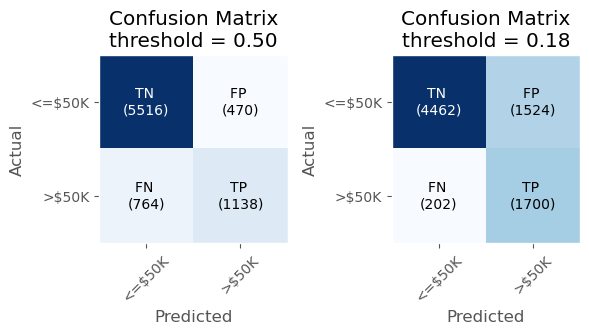

Threshold  0.500000  0.184612
Accuracy   0.843560  0.781187
Precision  0.707711  0.527295
Recall     0.598318  0.893796
F1 Score   0.648433  0.663285

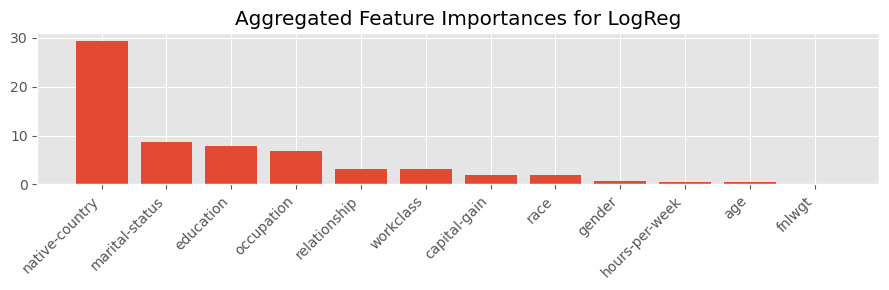


#######################################################################################################################################
Training KNN
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNN using best parameters:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5986
           1       0.68      0.59      0.63      1902

    accuracy                           0.83      7888
   macro avg       0.78      0.75      0.76      7888
weighted avg       0.83      0.83      0.83      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best Training Score for KNN: 0.512663904159701

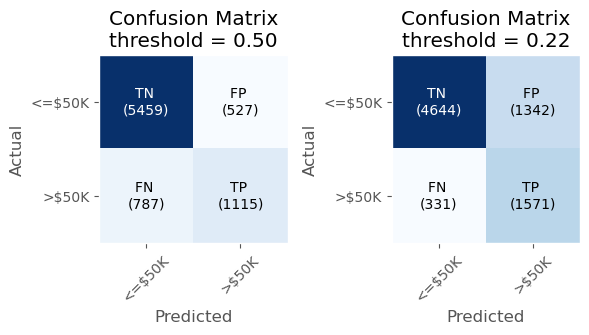

Threshold  0.500000  0.218518
Accuracy   0.833418  0.787906
Precision  0.679050  0.539307
Recall     0.586225  0.825973
F1 Score   0.629233  0.652544


#######################################################################################################################################
Training DecTree
#######################################################################################################################################
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Classification Report for DecTree using best parameters:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5986
           1       0.69      0.64      0.67      1902

    accuracy                           0.85      7888
   macro avg       0.79      0.78      0.78      7888
weighted avg       0.84      0.85      0.84      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for DecTree: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Training Score for DecTree: 

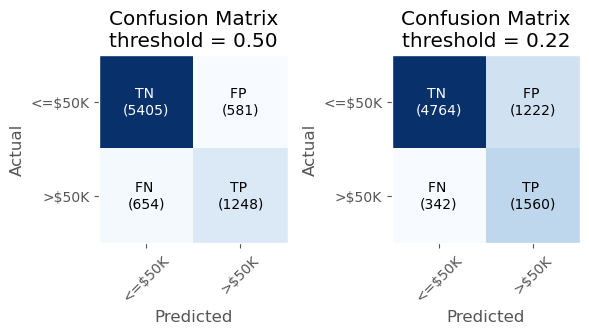

Threshold  0.500000  0.217391
Accuracy   0.843433  0.801724
Precision  0.682340  0.560748
Recall     0.656151  0.820189
F1 Score   0.668990  0.666097

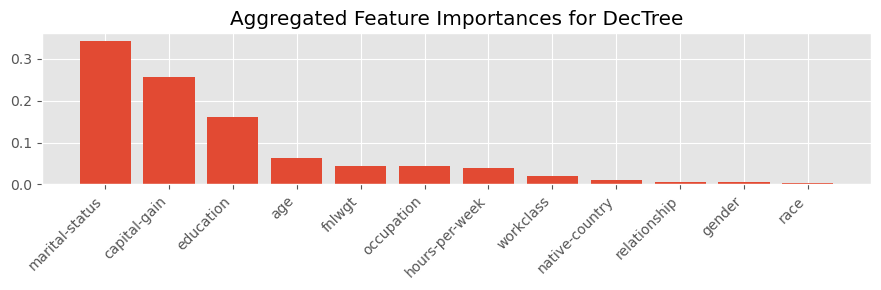


#######################################################################################################################################
Training RndForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RndForest using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      5986
           1       0.74      0.62      0.67      1902

    accuracy                           0.85      7888
   macro avg       0.81      0.77      0.79      7888
weighted avg       0.85      0.85      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RndForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best

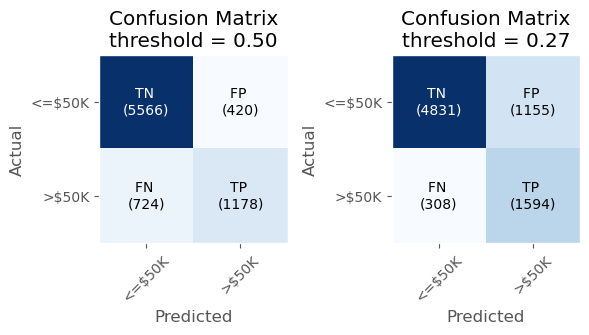

Threshold  0.500000  0.266306
Accuracy   0.854970  0.814528
Precision  0.737171  0.579847
Recall     0.619348  0.838065
F1 Score   0.673143  0.685444

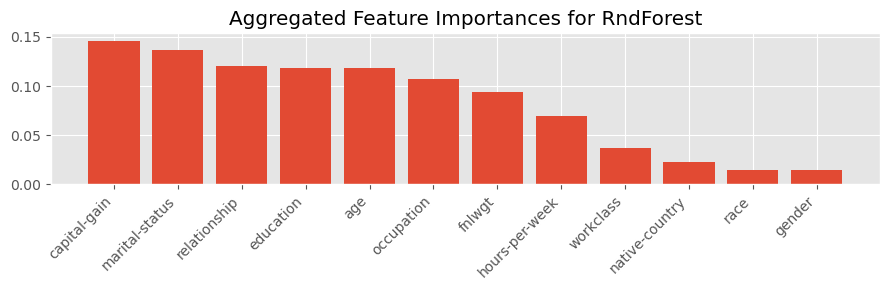


#######################################################################################################################################
Training NeuralNet
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/30
986/986 [==============================] - 1s 802us/step - loss: 0.3458 - Accuracy: 0.8379
Epoch 2/30
986/986 [==============================] - 1s 791us/step - loss: 0.3190 - Accuracy: 0.8530
Epoch 3/30
986/986 [==============================] - 1s 803us/step - loss: 0.3119 - Accuracy: 0.8585
Epoch 4/30
986/986 [==============================] - 1s 802us/step - loss: 0.3071 - Accuracy: 0.8584
Epoch 5/30
986/986 [==============================] - 1s 791us/step - loss: 0.3023 - Accuracy: 0.8628
Epoch 6/30
986/986 [==============================] - 1s 781us/step - loss: 0.3000 - Accuracy: 0.8626
Epoch 7/30
986/986 [==============

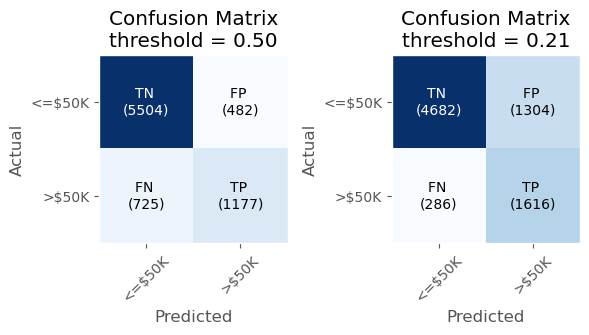

Threshold  0.500000  0.212774
Accuracy   0.846983  0.798428
Precision  0.709464  0.553425
Recall     0.618822  0.849632
F1 Score   0.661050  0.670261


#######################################################################################################################################
Training SVM
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for SVM using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5986
           1       0.72      0.61      0.66      1902

    accuracy                           0.85      7888
   macro avg       0.80      0.77      0.78      7888
weighted avg       0.84      0.85      0.84      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Score for SVM: 0.5565404830692822
Training duration: 

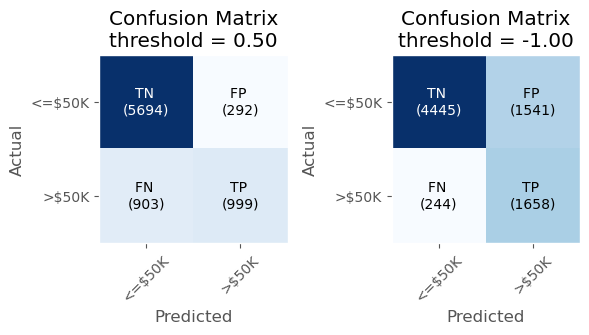

Threshold   0.500000  -1.004248
Accuracy    0.848504   0.773707
Precision   0.773819   0.518287
Recall      0.525237   0.871714
F1 Score    0.625744   0.650069

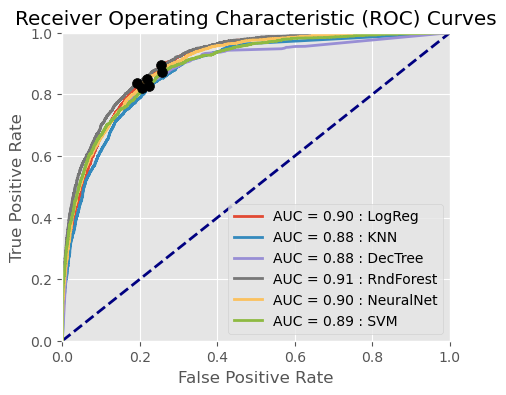

In [25]:
#RUN ANALYSIS #1: NATIVE- AND FOREIGN-BORN INDIVIDUALS W/ MODELS SCORED ON INFORMEDNESS FOR ORIGINAL UNBALANCED DATASET

target_col     = "income_>50K"
model_select   = [ 'LogReg', 'KNN', 'DecTree', 'RndForest', 'NeuralNet', 'SVM' ]
resample_ratio = -1
scoring_method = "informedness" # Can be: accuracy, gmeans, informedness, roc_auc, f1, precision, recall, average_precision

run_models(df_all, target_col, model_select, resample_ratio, scoring_method)

Before resampling:
 income_>50K
0    23769
1     7781
Name: count, dtype: int64
After resampling :
 income_>50K
0    23769
1     7781
Name: count, dtype: int64

#######################################################################################################################################
Training LogReg
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogReg using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5986
           1       0.71      0.60      0.65      1902

    accuracy                           0.84      7888
   macro avg       0.79      0.76      0.77      7888
weighted avg       0.84      0.84      0.84      7888

-----------------------------------------------------------------------------------------------------------

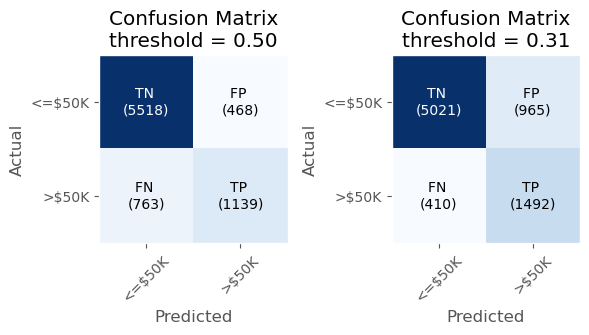

Threshold  0.500000  0.305296
Accuracy   0.843940  0.825685
Precision  0.708774  0.607245
Recall     0.598843  0.784437
F1 Score   0.649188  0.684561

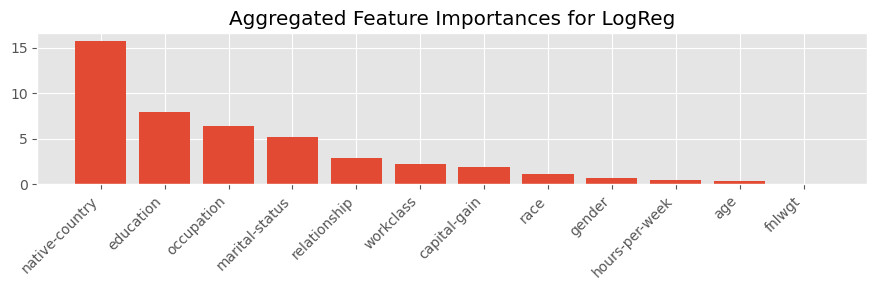


#######################################################################################################################################
Training KNN
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNN using best parameters:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5986
           1       0.68      0.59      0.63      1902

    accuracy                           0.83      7888
   macro avg       0.78      0.75      0.76      7888
weighted avg       0.83      0.83      0.83      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best Training Score for KNN: 0.642917396909928

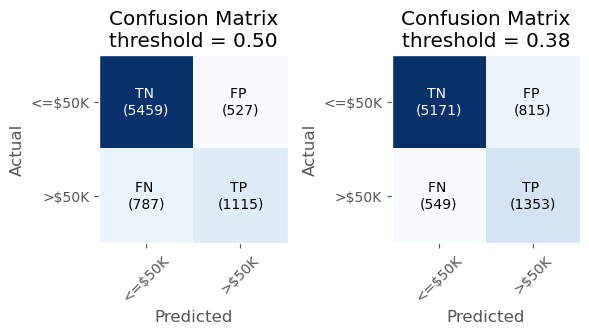

Threshold   0.50000   0.38096
Accuracy   0.833418  0.827079
Precision  0.679050  0.624077
Recall     0.586225  0.711356
F1 Score   0.629233  0.664865


#######################################################################################################################################
Training DecTree
#######################################################################################################################################
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Classification Report for DecTree using best parameters:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5986
           1       0.70      0.64      0.67      1902

    accuracy                           0.85      7888
   macro avg       0.79      0.78      0.78      7888
weighted avg       0.84      0.85      0.84      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for DecTree: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Training Score for DecTree: 

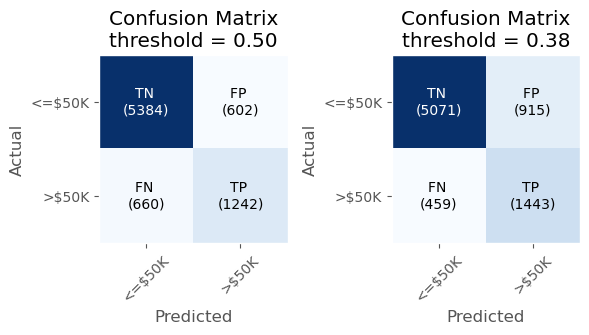

Threshold  0.500000  0.380952
Accuracy   0.840010  0.825811
Precision  0.673536  0.611959
Recall     0.652997  0.758675
F1 Score   0.663107  0.677465

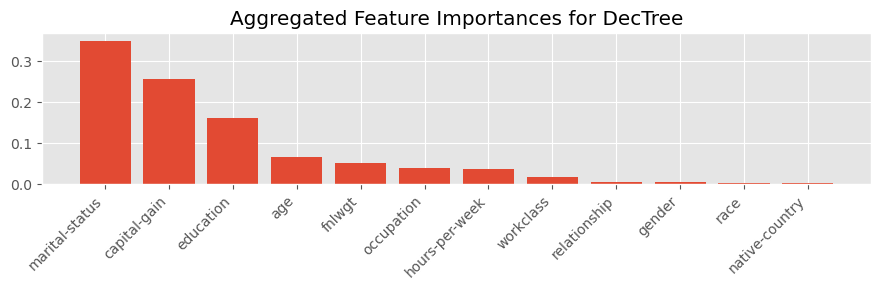


#######################################################################################################################################
Training RndForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RndForest using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5986
           1       0.76      0.61      0.68      1902

    accuracy                           0.86      7888
   macro avg       0.82      0.78      0.79      7888
weighted avg       0.85      0.86      0.85      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RndForest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Bes

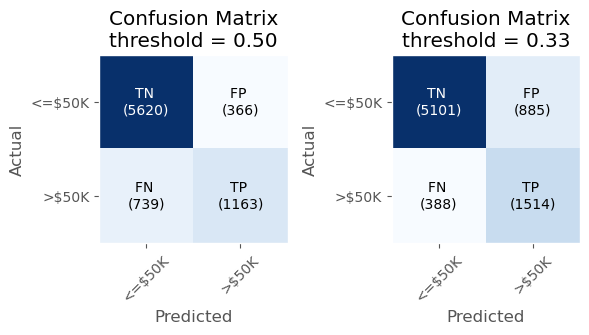

Threshold  0.500000  0.332921
Accuracy   0.859914  0.838616
Precision  0.760628  0.631096
Recall     0.611462  0.796004
F1 Score   0.677936  0.704022

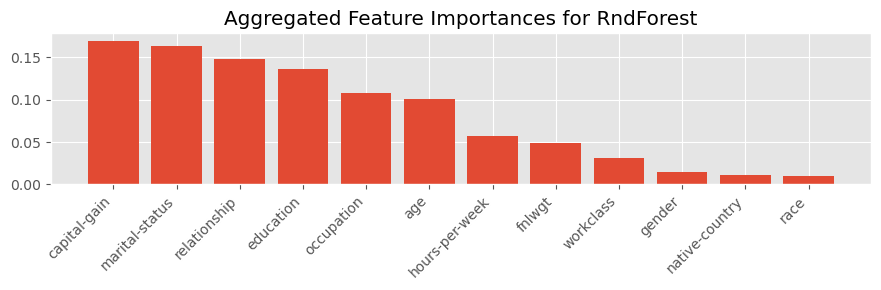


#######################################################################################################################################
Training NeuralNet
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/20
986/986 [==============================] - 1s 648us/step - loss: 0.3393 - Accuracy: 0.8415
Epoch 2/20
986/986 [==============================] - 1s 639us/step - loss: 0.3137 - Accuracy: 0.8543
Epoch 3/20
986/986 [==============================] - 1s 641us/step - loss: 0.3069 - Accuracy: 0.8578
Epoch 4/20
986/986 [==============================] - 1s 641us/step - loss: 0.3018 - Accuracy: 0.8619
Epoch 5/20
986/986 [==============================] - 1s 640us/step - loss: 0.2976 - Accuracy: 0.8634
Epoch 6/20
986/986 [==============================] - 1s 649us/step - loss: 0.2945 - Accuracy: 0.8634
Epoch 7/20
986/986 [==============

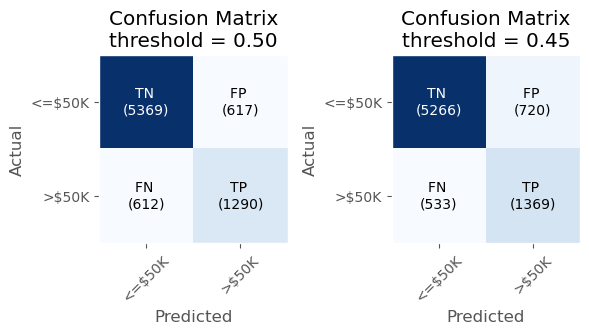

Threshold  0.500000  0.454372
Accuracy   0.844194  0.841151
Precision  0.676455  0.655337
Recall     0.678233  0.719769
F1 Score   0.677343  0.686044


#######################################################################################################################################
Training SVM
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for SVM using best parameters:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5986
           1       0.72      0.61      0.66      1902

    accuracy                           0.85      7888
   macro avg       0.80      0.77      0.78      7888
weighted avg       0.84      0.85      0.84      7888

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Score for SVM: 0.6803843815946976
Training duration: 

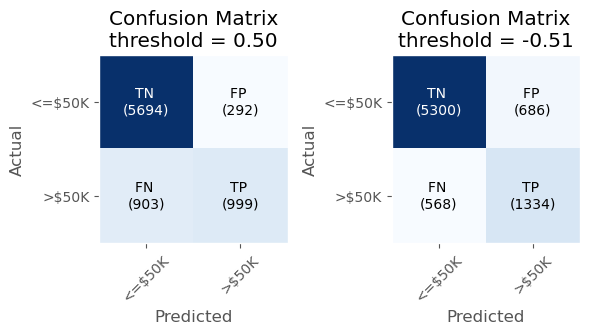

Threshold   0.500000  -0.511252
Accuracy    0.848504   0.841024
Precision   0.773819   0.660396
Recall      0.525237   0.701367
F1 Score    0.625744   0.680265

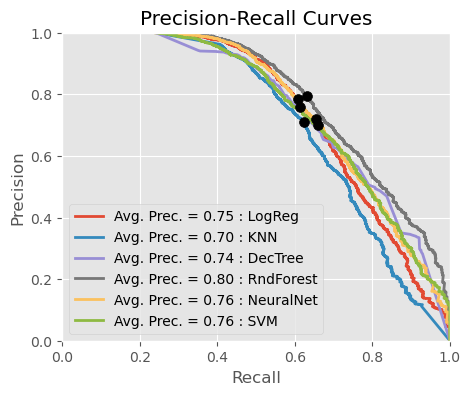

In [26]:
#RUN ANALYSIS #5: NATIVE- AND FOREIGN-BORN INDIVIDUALS W/ MODELS SCORED ON F1 FOR ORIGINAL UNBALANCED DATASET

target_col     = "income_>50K"
model_select   = [ 'LogReg', 'KNN', 'DecTree', 'RndForest', 'NeuralNet', 'SVM' ]
resample_ratio = -1
scoring_method = "f1" # Can be: accuracy, gmeans, informedness, roc_auc, f1, precision, recall, average_precision

run_models(df_all, target_col, model_select, resample_ratio, scoring_method)

Before resampling:
 income_>50K
0    2263
1     490
Name: count, dtype: int64
After resampling :
 income_>50K
0    2263
1     490
Name: count, dtype: int64

#######################################################################################################################################
Training LogReg
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogReg using best parameters:
              precision    recall  f1-score   support

           0       0.87      0.95      0.90       541
           1       0.71      0.46      0.56       148

    accuracy                           0.84       689
   macro avg       0.79      0.70      0.73       689
weighted avg       0.83      0.84      0.83       689

---------------------------------------------------------------------------------------------------------------

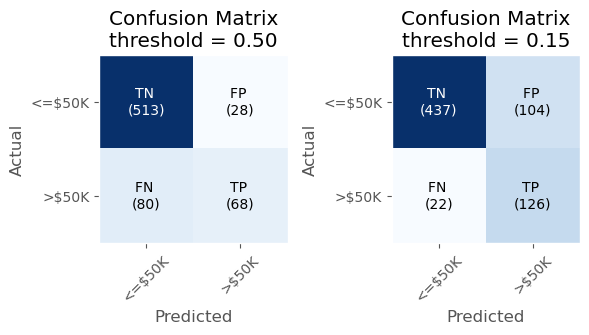

Threshold  0.500000  0.151966
Accuracy   0.843251  0.817126
Precision  0.708333  0.547826
Recall     0.459459  0.851351
F1 Score   0.557377  0.666667

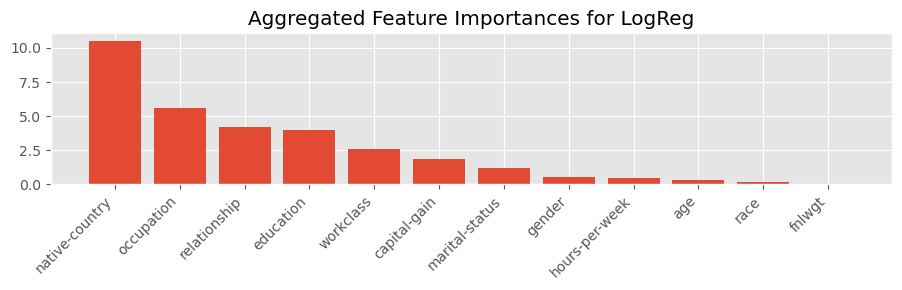


#######################################################################################################################################
Training KNN
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNN using best parameters:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       541
           1       0.66      0.43      0.52       148

    accuracy                           0.83       689
   macro avg       0.76      0.68      0.71       689
weighted avg       0.82      0.83      0.82       689

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best Training Score for KNN: 0.592563822644545

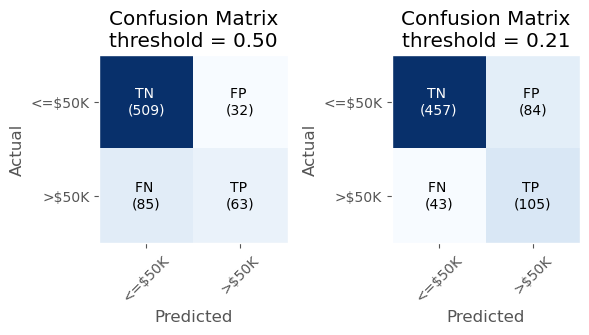

Threshold   0.50000   0.20956
Accuracy   0.830189  0.815675
Precision  0.663158  0.555556
Recall     0.425676  0.709459
F1 Score   0.518519  0.623145


#######################################################################################################################################
Training DecTree
#######################################################################################################################################
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Classification Report for DecTree using best parameters:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       541
           1       0.65      0.57      0.61       148

    accuracy                           0.84       689
   macro avg       0.77      0.75      0.76       689
weighted avg       0.84      0.84      0.84       689

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for DecTree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Training Score for DecTree: 0.

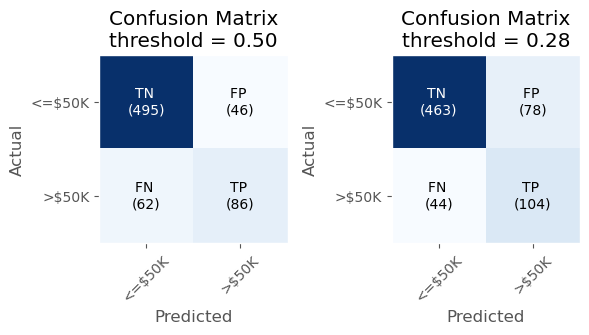

Threshold   0.50000   0.28022
Accuracy   0.843251  0.822932
Precision  0.651515  0.571429
Recall     0.581081  0.702703
F1 Score   0.614286  0.630303

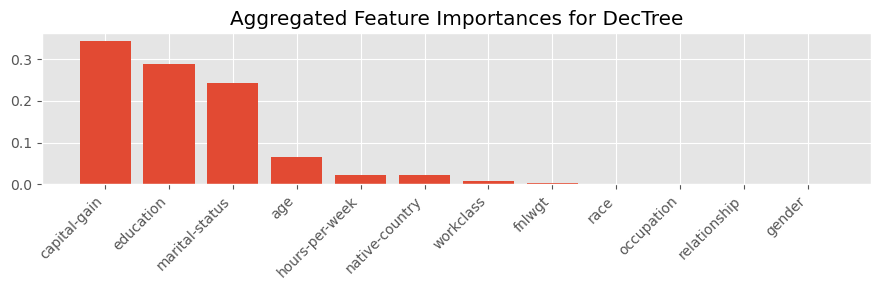


#######################################################################################################################################
Training RndForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RndForest using best parameters:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       541
           1       0.74      0.49      0.59       148

    accuracy                           0.85       689
   macro avg       0.81      0.72      0.75       689
weighted avg       0.84      0.85      0.84       689

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RndForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best

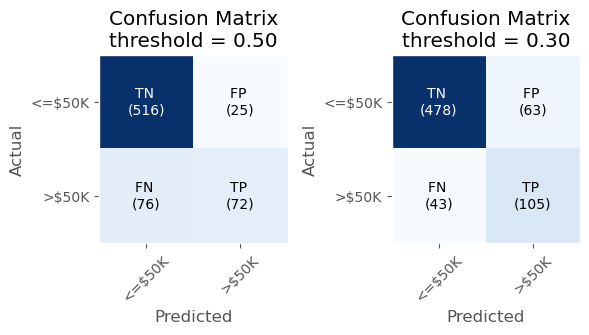

Threshold  0.500000  0.301655
Accuracy   0.853411  0.846154
Precision  0.742268  0.625000
Recall     0.486486  0.709459
F1 Score   0.587755  0.664557

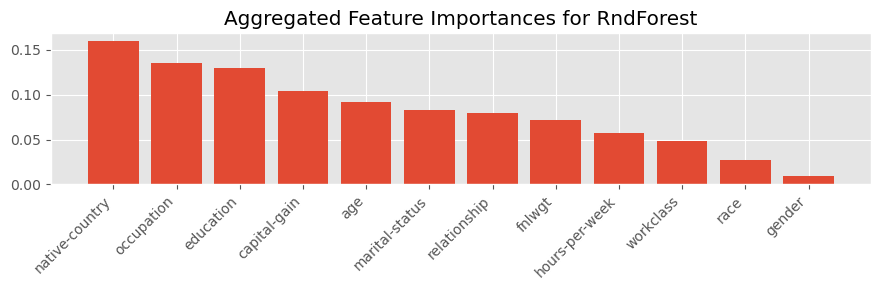


#######################################################################################################################################
Training NeuralNet
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/20
87/87 [==============================] - 0s 719us/step - loss: 0.4238 - Accuracy: 0.8020
Epoch 2/20
87/87 [==============================] - 0s 657us/step - loss: 0.2804 - Accuracy: 0.8732
Epoch 3/20
87/87 [==============================] - 0s 626us/step - loss: 0.2550 - Accuracy: 0.8856
Epoch 4/20
87/87 [==============================] - 0s 640us/step - loss: 0.2404 - Accuracy: 0.8979
Epoch 5/20
87/87 [==============================] - 0s 634us/step - loss: 0.2282 - Accuracy: 0.9001
Epoch 6/20
87/87 [==============================] - 0s 640us/step - loss: 0.2199 - Accuracy: 0.9027
Epoch 7/20
87/87 [============================

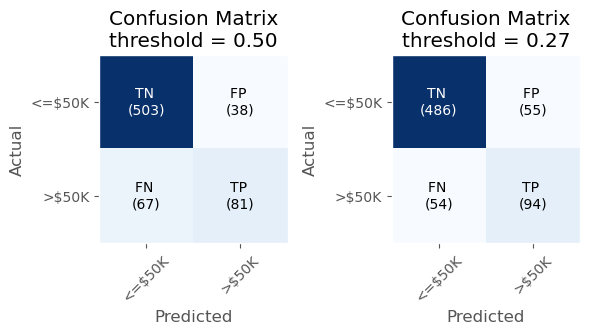

Threshold  0.500000  0.269216
Accuracy   0.847605  0.841800
Precision  0.680672  0.630872
Recall     0.547297  0.635135
F1 Score   0.606742  0.632997


#######################################################################################################################################
Training SVM
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for SVM using best parameters:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       541
           1       0.73      0.48      0.58       148

    accuracy                           0.85       689
   macro avg       0.80      0.72      0.74       689
weighted avg       0.84      0.85      0.84       689

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Training Score for SVM: 0.6304989625456104
Training duration: 3

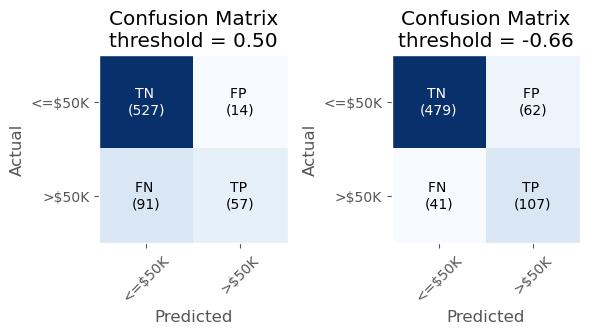

Threshold   0.500000  -0.659241
Accuracy    0.847605   0.850508
Precision   0.802817   0.633136
Recall      0.385135   0.722973
F1 Score    0.520548   0.675079

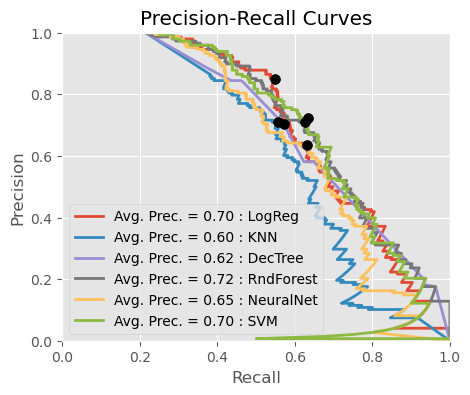

In [27]:
#RUN ANALYSIS #5: NATIVE- AND FOREIGN-BORN INDIVIDUALS W/ MODELS SCORED ON F1 FOR ORIGINAL UNBALANCED DATASET

target_col     = "income_>50K"
model_select   = [ 'LogReg', 'KNN', 'DecTree', 'RndForest', 'NeuralNet', 'SVM' ]
resample_ratio = -1
scoring_method = "f1" # Can be: accuracy, gmeans, informedness, roc_auc, f1, precision, recall, average_precision

run_models(df_foreign, target_col, model_select, resample_ratio, scoring_method)